In [239]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')

base_feats = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

## 1. 데이터 로딩

data_dir = '/opt/ml/input/data' # 경로
train_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터
test_file_path = os.path.join(data_dir, 'test_data.csv')
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)
df_test1 = df_test[df_test.answerCode!=-1]  # answer_code -1 제외
df_test2 = df_test[df_test.answerCode==-1] # answer_code -1 애들만

df_train.shape, df_test1.shape, df_test2.shape

((2266586, 6), (259370, 6), (744, 6))

In [404]:
day_dict_rev={
    6: 'Sunday',
    2: 'Monday',
    0: 'Tuesday',
    5: 'Wednesday',
    1: 'Thursday',
    4: 'Friday',
    3: 'Saturday',
}

day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}
def feature_engineering(df):
    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['date'] = pd.to_datetime(df2['Timestamp']).dt.date
    df2['month'] = pd.to_datetime(df2['Timestamp']).dt.month
    df2['day'] = pd.to_datetime(df2['Timestamp']).dt.day
    df2['hour'] = pd.to_datetime(df2['Timestamp']).dt.hour
    df2['dayname'] = pd.to_datetime(df2['Timestamp']).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))
    
    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    return df2

train_fe = feature_engineering(df_train)
test1_fe = feature_engineering(df_test1)
test2_fe = feature_engineering(df_test2)
train_fe.shape, test1_fe.shape, test2_fe.shape

((2266586, 23), (259370, 23), (744, 23))

## Riiid CV Strategy
- Second Solution
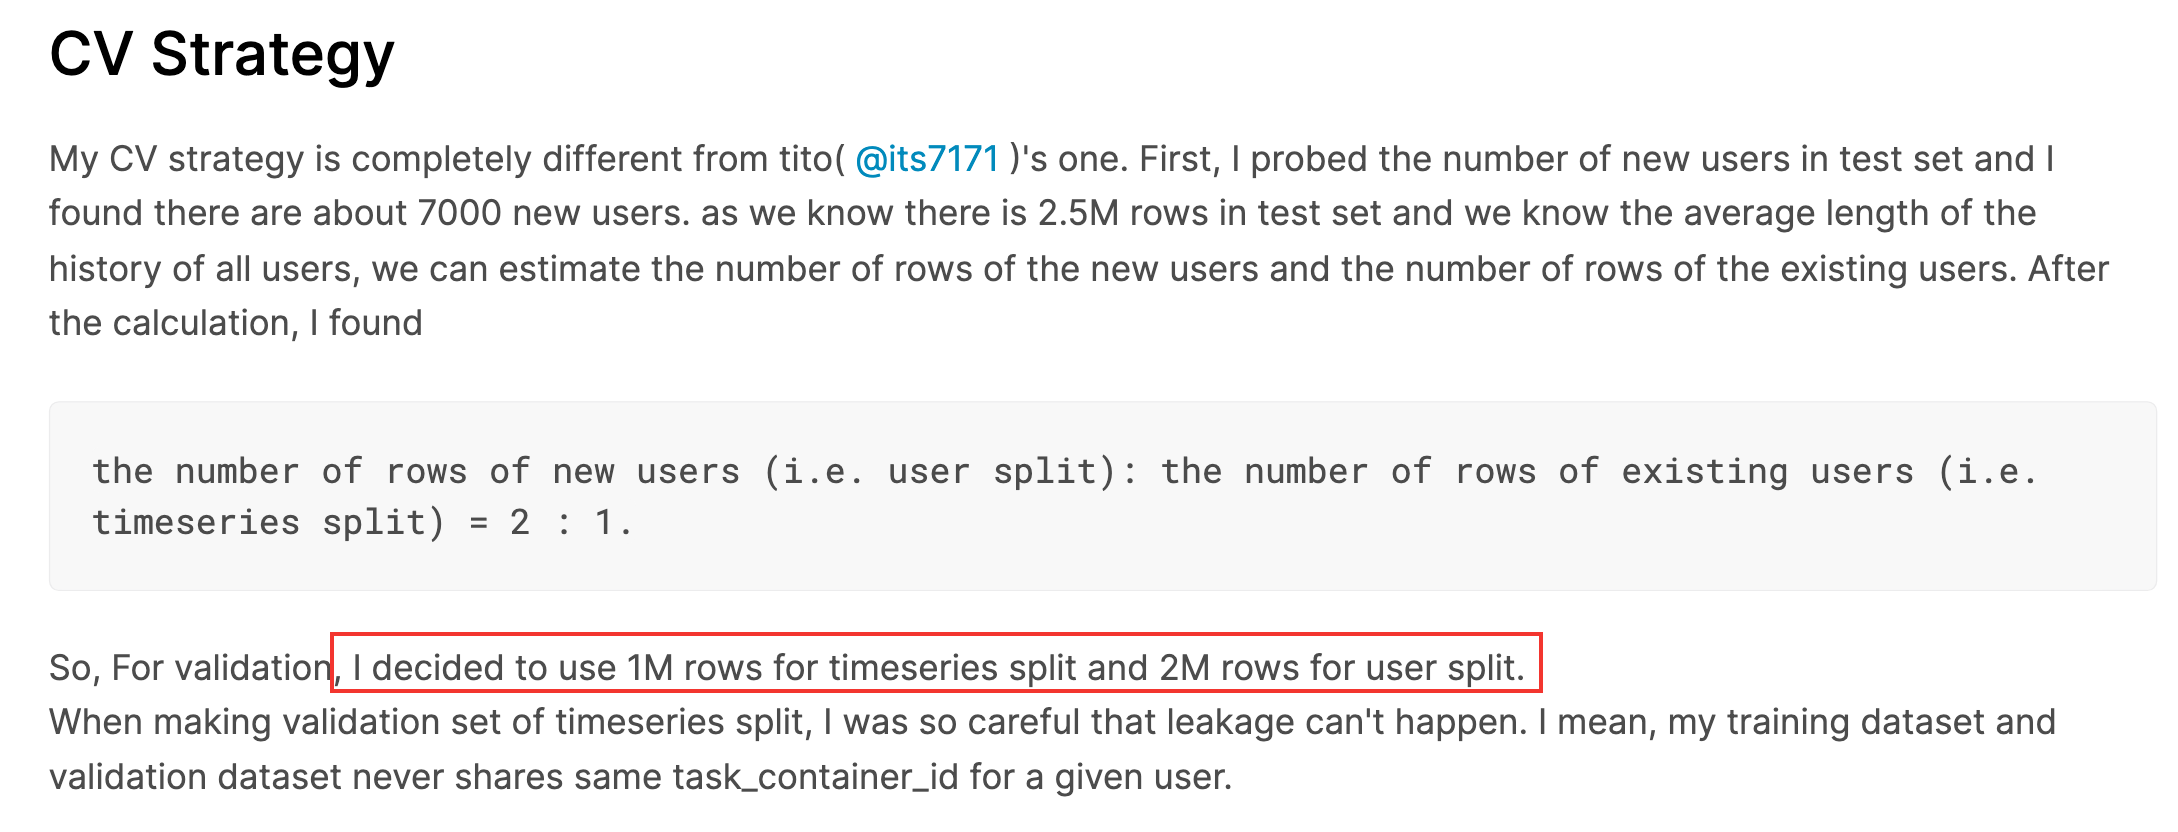
출처: https://www.kaggle.com/competitions/riiid-test-answer-prediction/discussion/210113
        
tito(grandmaster)의 또다른 CV Strategy: https://www.kaggle.com/code/its7171/cv-strategy/notebook

CV Discussion: https://www.kaggle.com/competitions/riiid-test-answer-prediction/discussion/192919

cv 전략에 대한 의견: https://www.kaggle.com/competitions/riiid-test-answer-prediction/discussion/196942

-> train/test가 나뉜 방향을 mimic해서 train / validation을 나눠라!

## train과 test timeseries 보기

<Figure size 5000x1000 with 0 Axes>

<AxesSubplot:xlabel='date'>

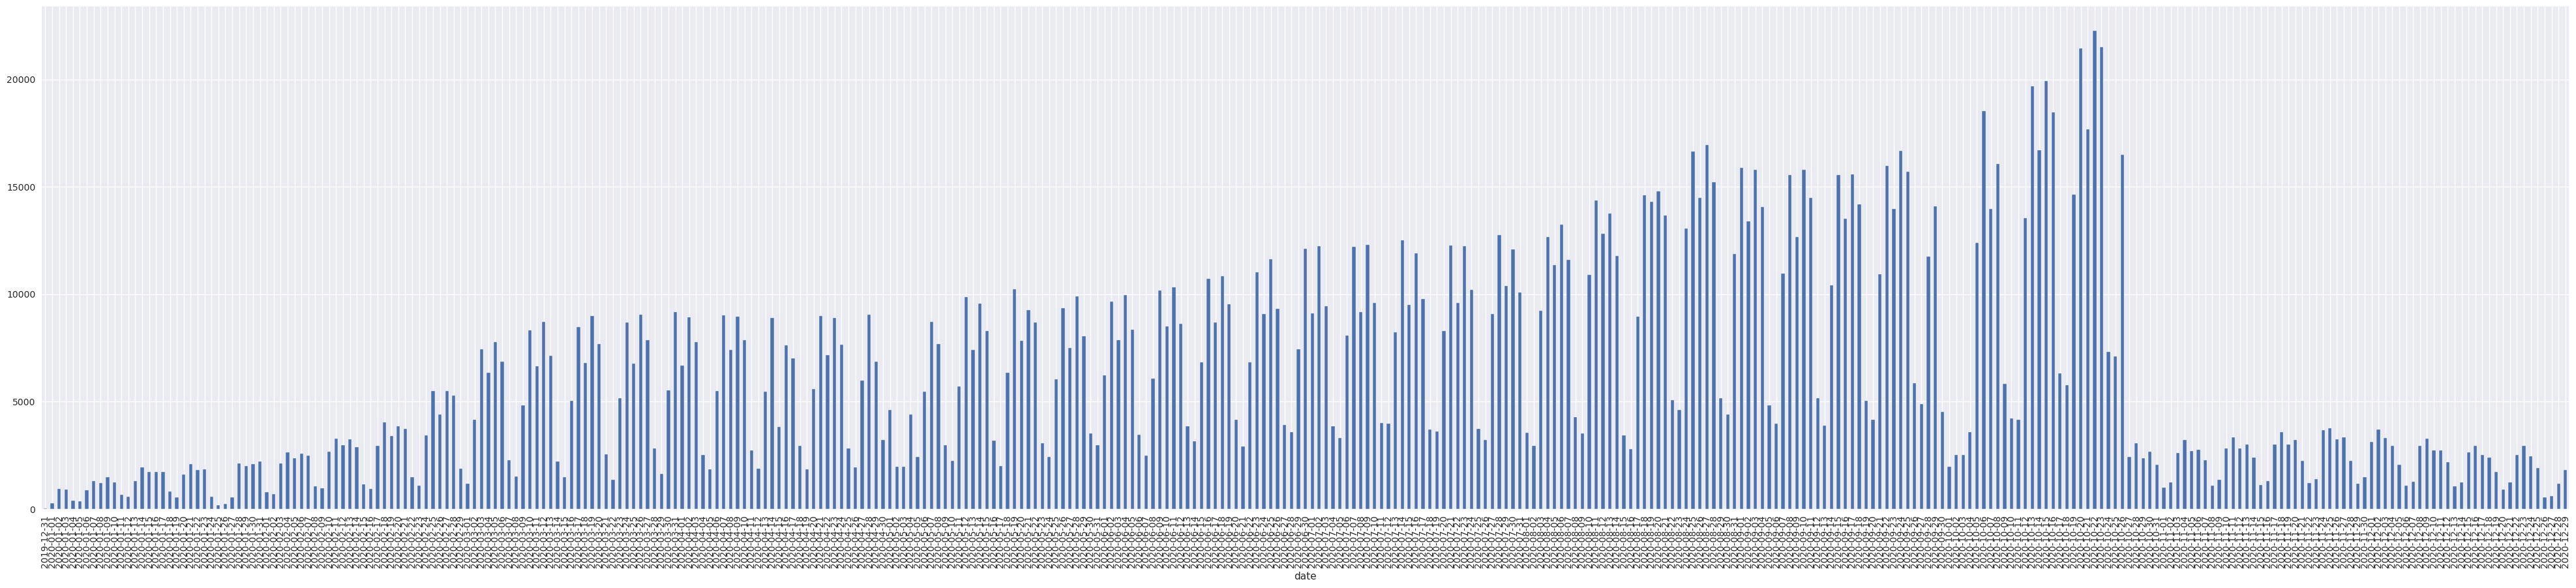

In [241]:
plt.figure(figsize=(50,10))
train_fe.groupby(['date']).size().plot(kind = 'bar')

<Figure size 5000x1000 with 0 Axes>

<AxesSubplot:xlabel='date'>

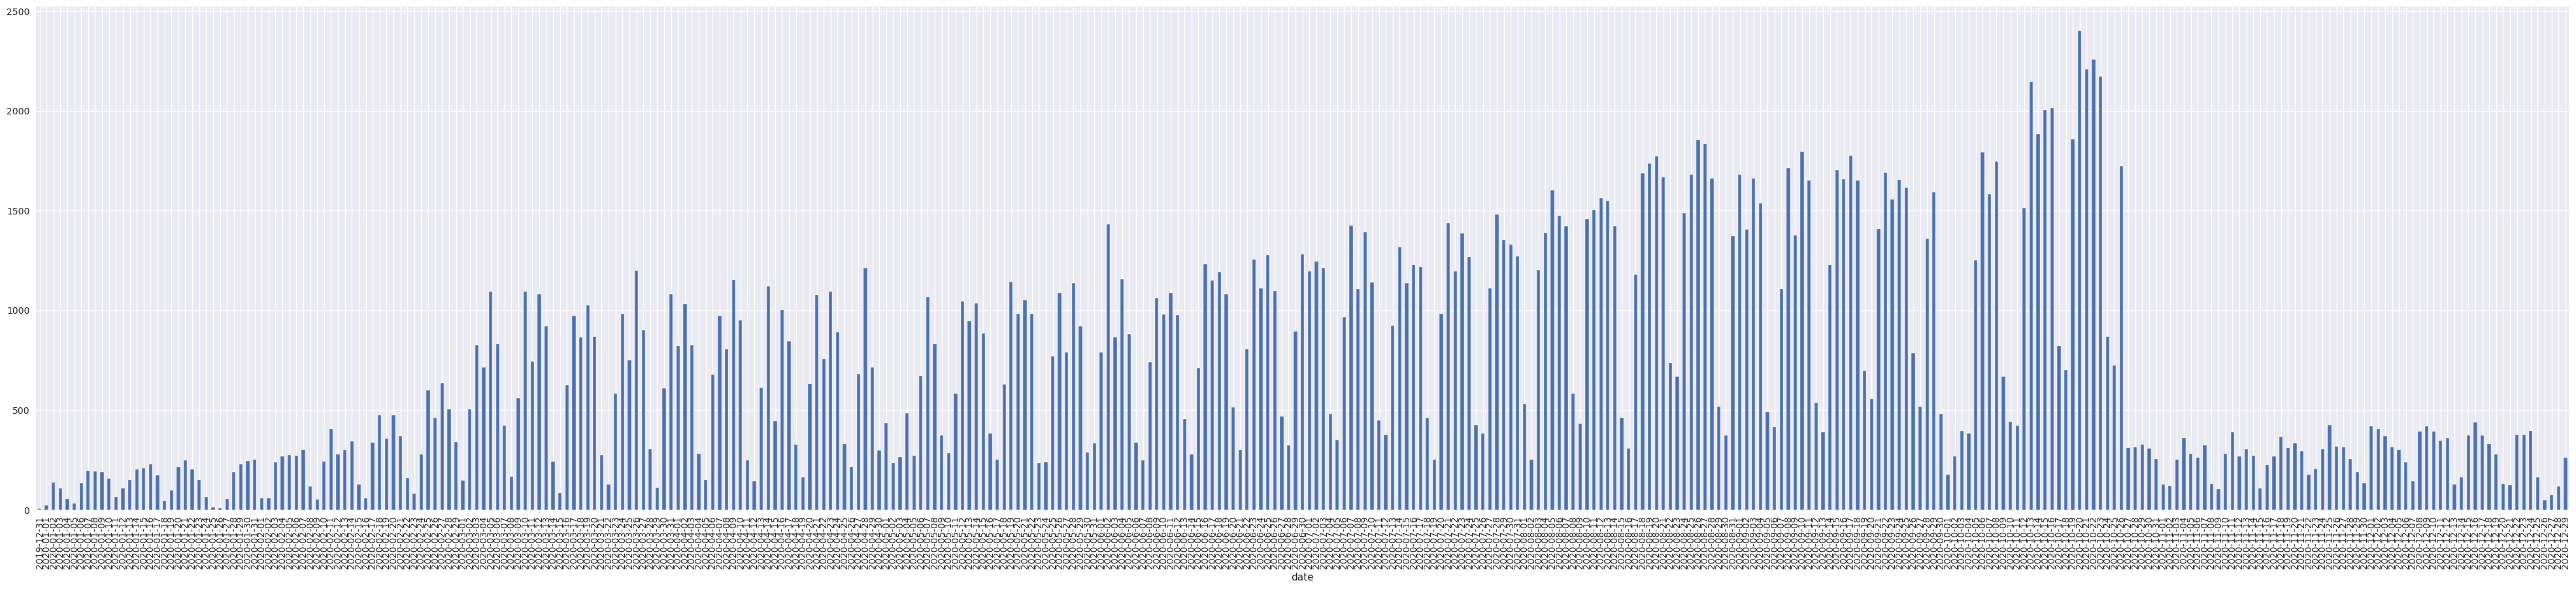

In [242]:
plt.figure(figsize=(50,10))
test1_fe.groupby(['date']).size().plot(kind = 'bar')

<Figure size 5000x1000 with 0 Axes>

<AxesSubplot:xlabel='date'>

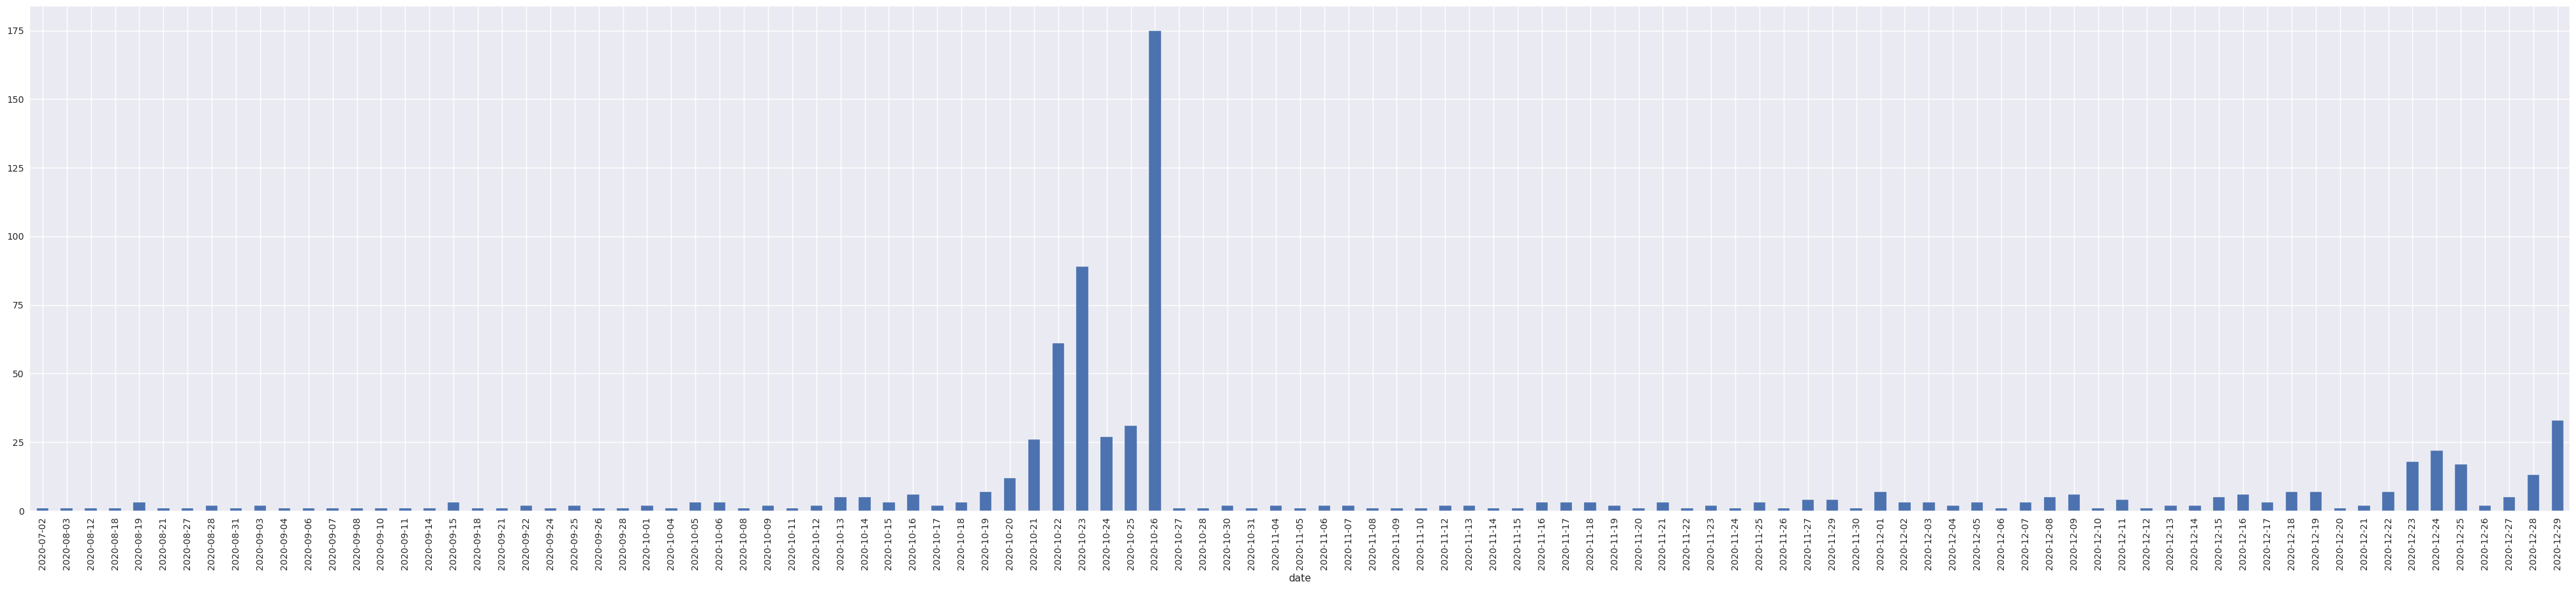

In [243]:
plt.figure(figsize=(50,10))
test2_fe.groupby(['date']).size().plot(kind = 'bar')

### 정답률

### timeseries 정답률

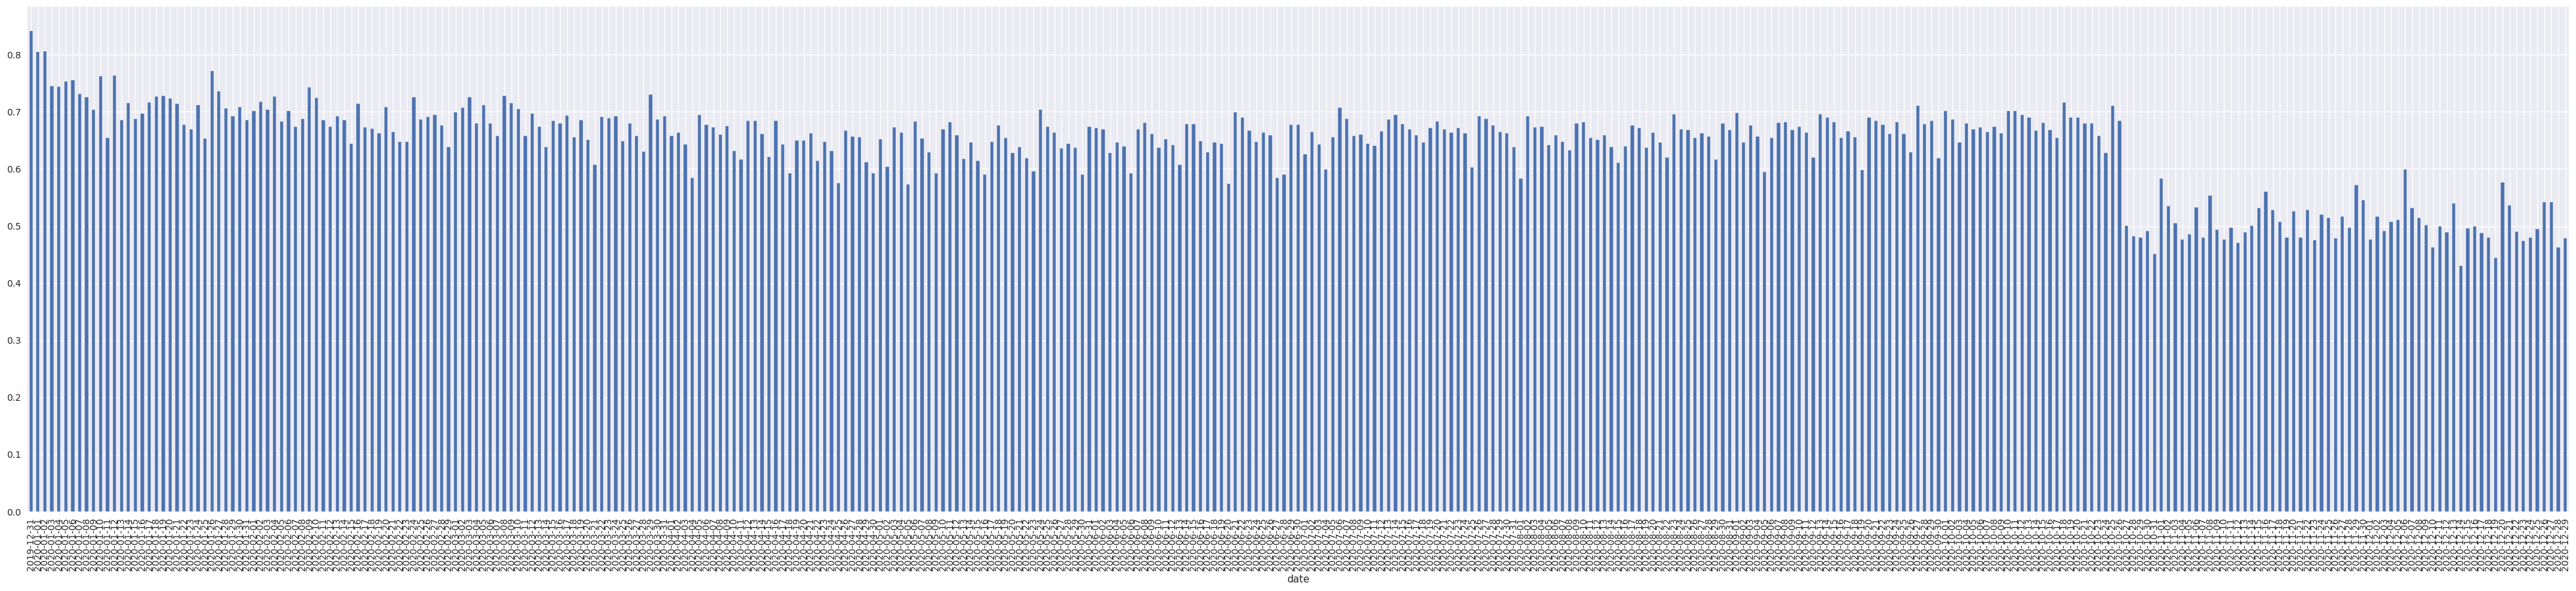

In [244]:
q = plt.figure(figsize=(50,10))
q = train_fe.groupby('date')['answerCode'].mean().plot(kind = 'bar')

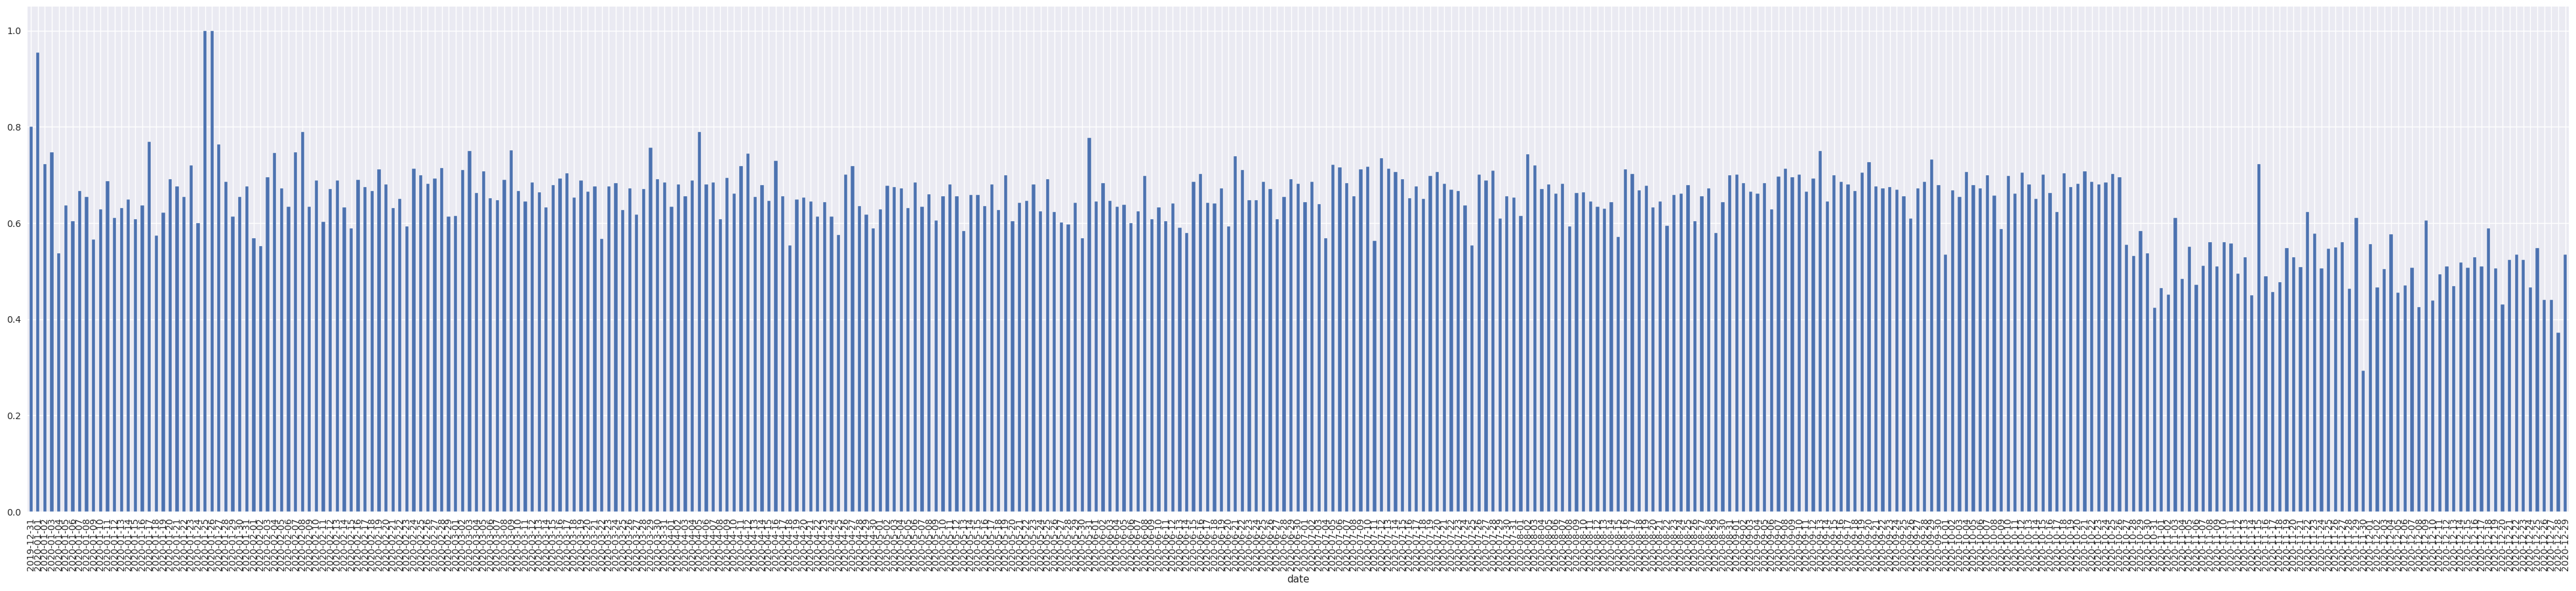

In [245]:
q = plt.figure(figsize=(50,10))
q = test1_fe.groupby('date')['answerCode'].mean().plot(kind = 'bar')

### 요일별 정답률

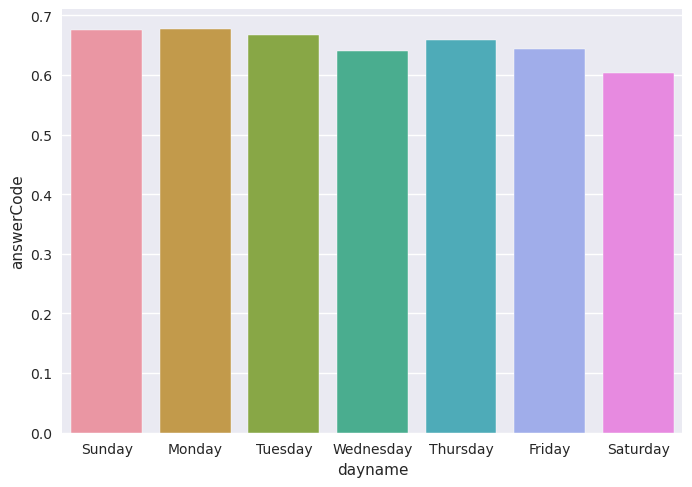

In [247]:
df = train_fe.groupby('dayname')['answerCode'].mean().reset_index()
df['dayname'] = df.dayname.map(day_dict_rev)

interest_li = ['Sunday', 'Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday','Saturday']
df_sort = df[df['dayname'].isin(interest_li)].copy() # 먼저, 데이터 프레임에서 관심값 추출
sorterIndex = dict(zip(interest_li, range(len(interest_li)))) # 정렬을 위한 dictionary 생성
df_sort['sorter'] = df_sort['dayname'].map(sorterIndex) # 해당 dictionary를 이용해 정렬을 위한 열('sorter') 생성
df_sort.sort_values('sorter',inplace=True) # sorter를 기준으로 정렬
df_sort.drop('sorter', 1, inplace = True) # sorter 열 삭제
df_sort.reset_index(drop=True,inplace=True)

q = sns.barplot(df_sort, x='dayname', y='answerCode')

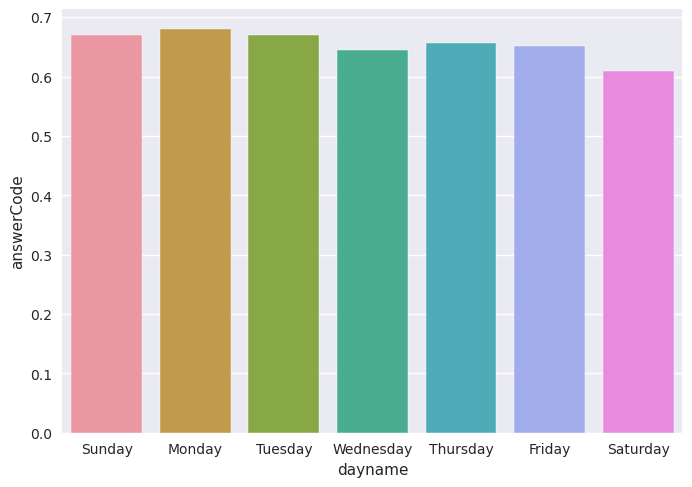

In [248]:
df = test1_fe.groupby('dayname')['answerCode'].mean().reset_index()
df['dayname'] = df.dayname.map(day_dict_rev)

interest_li = ['Sunday', 'Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday','Saturday']
df_sort = df[df['dayname'].isin(interest_li)].copy() # 먼저, 데이터 프레임에서 관심값 추출
sorterIndex = dict(zip(interest_li, range(len(interest_li)))) # 정렬을 위한 dictionary 생성
df_sort['sorter'] = df_sort['dayname'].map(sorterIndex) # 해당 dictionary를 이용해 정렬을 위한 열('sorter') 생성
df_sort.sort_values('sorter',inplace=True) # sorter를 기준으로 정렬
df_sort.drop('sorter', 1, inplace = True) # sorter 열 삭제
df_sort.reset_index(drop=True,inplace=True)

q = sns.barplot(df_sort, x='dayname', y='answerCode')

In [116]:
train_ab = train_fe[train_fe.date.map(str)=='2020-11-15']
train_ab.groupby('userID')['answerCode'].agg(['count','mean','std'])

,count,mean,std
userID,,,
24,8,0.250000,0.462910
31,9,1.000000,0.000000
39,7,1.000000,0.000000
48,8,0.625000,0.517549
61,8,1.000000,0.000000
96,8,0.500000,0.534522
117,8,1.000000,0.000000
132,8,0.250000,0.462910
143,14,0.571429,0.513553


In [118]:
test_ab = train_fe2[train_fe2.date.map(str)=='2020-11-15']
test_ab.groupby('userID')['answerCode'].agg(['count','mean','std'])

,count,mean,std
userID,,,
4,8,0.625000,0.517549
79,11,1.000000,0.000000
193,8,0.750000,0.462910
361,7,0.285714,0.487950
414,8,1.000000,0.000000
617,16,0.500000,0.516398
802,14,1.000000,0.000000
1503,8,0.875000,0.353553
1828,6,0.666667,0.516398


## 유저별 그룹화

### train set

In [406]:
q1=[0,0.2,0.4,0.6,0.8,1]
q2=[0,0.3,0.55,0.7,0.9,1]

train_fe['group'] = pd.qcut(train_fe['userID'], q=q1, labels=[1,2,3,4,5])

train_fe['valid']=0
train_fe.loc[train_fe['userID'] != train_fe['userID'].shift(-1),'valid']=1

--- group1 INFORMATIONS ---
    shape            : (453971, 25)
    userID           : 563
    assessmentItemID : 9454
    testID           : 1537
    mean answer rate : 66.56%
    KnowledgeTag     : 912
--------------------------
--- group1 valid INFORMATIONS ---
    shape            : (563, 25)
    userID           : 563
    assessmentItemID : 351
    testID           : 316
    mean answer rate : 50.62%
    KnowledgeTag     : 229
--------------------------


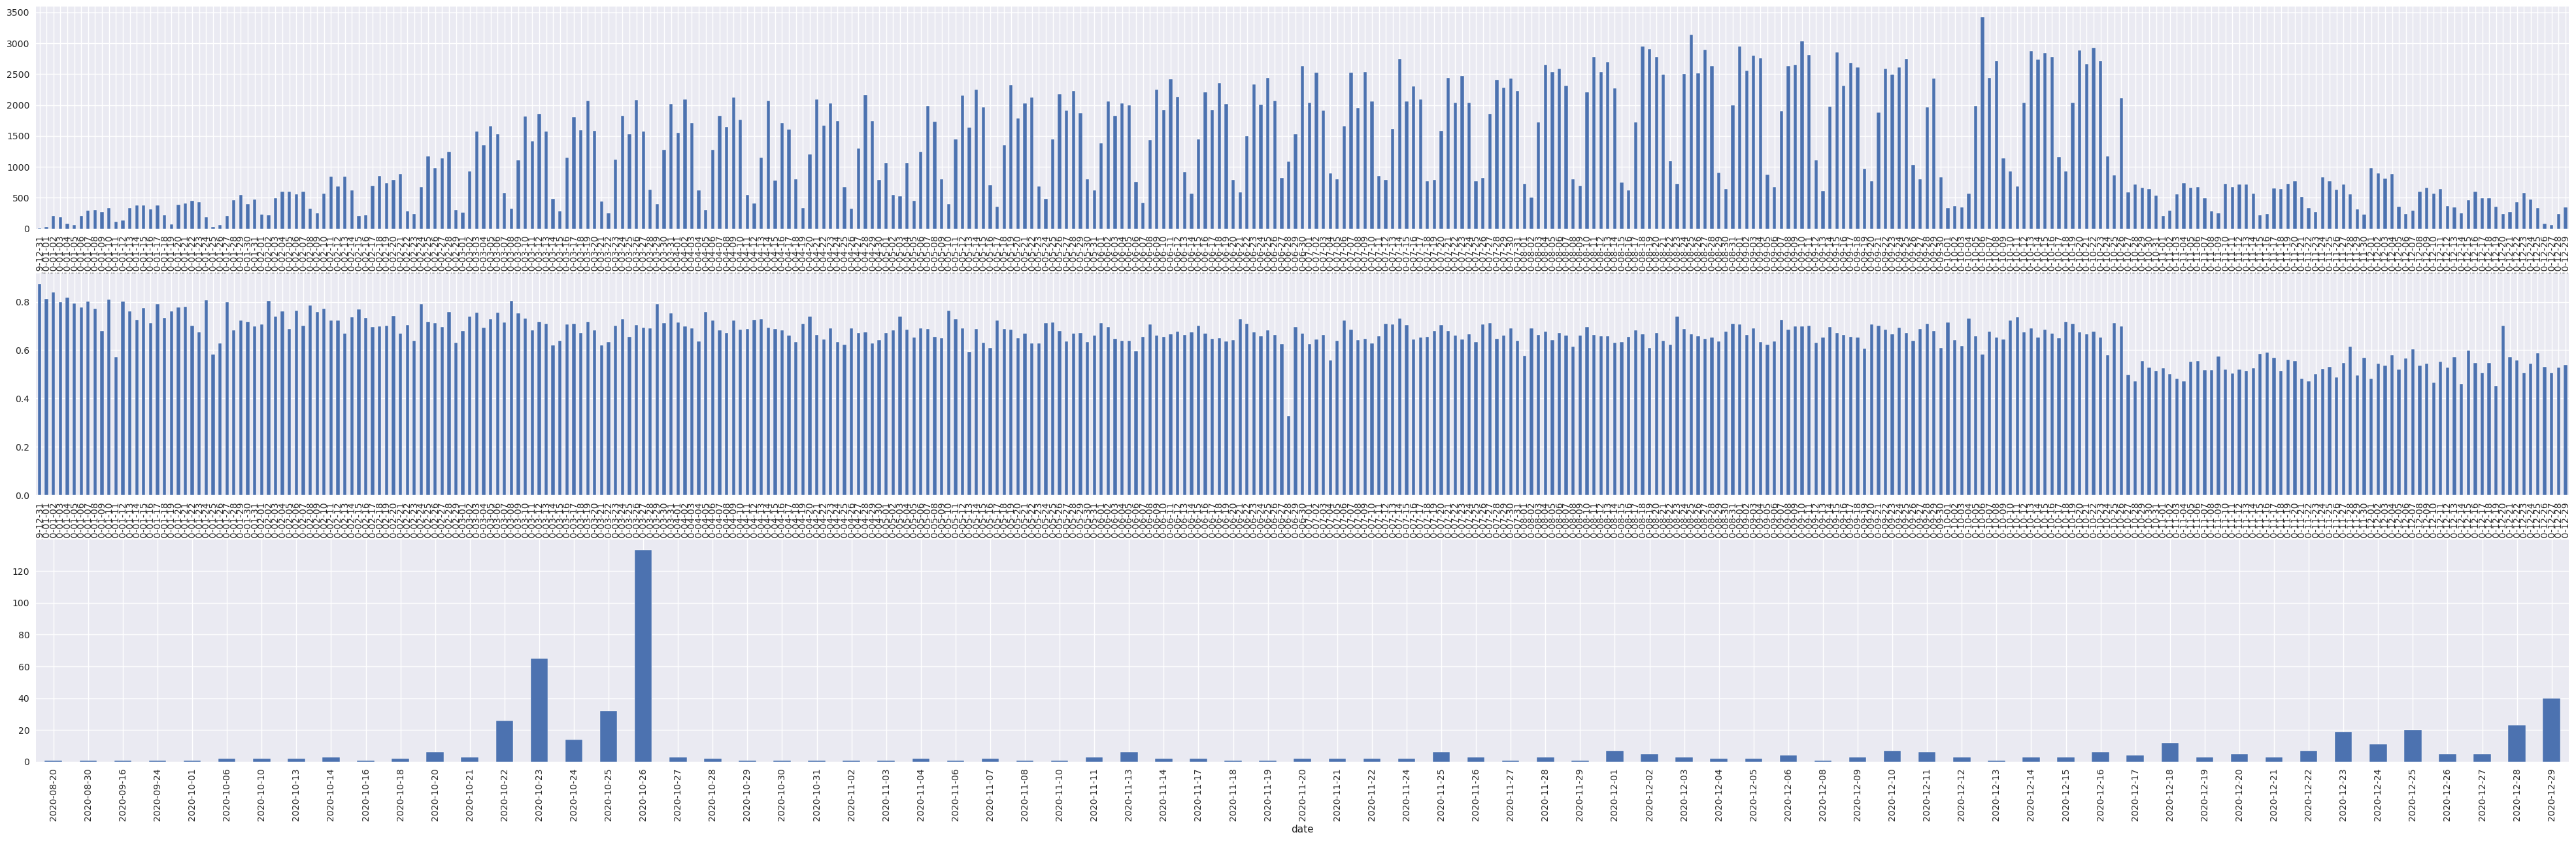

--- group2 INFORMATIONS ---
    shape            : (452902, 25)
    userID           : 633
    assessmentItemID : 9454
    testID           : 1537
    mean answer rate : 67.65%
    KnowledgeTag     : 912
--------------------------
--- group2 valid INFORMATIONS ---
    shape            : (633, 25)
    userID           : 633
    assessmentItemID : 385
    testID           : 345
    mean answer rate : 46.29%
    KnowledgeTag     : 253
--------------------------


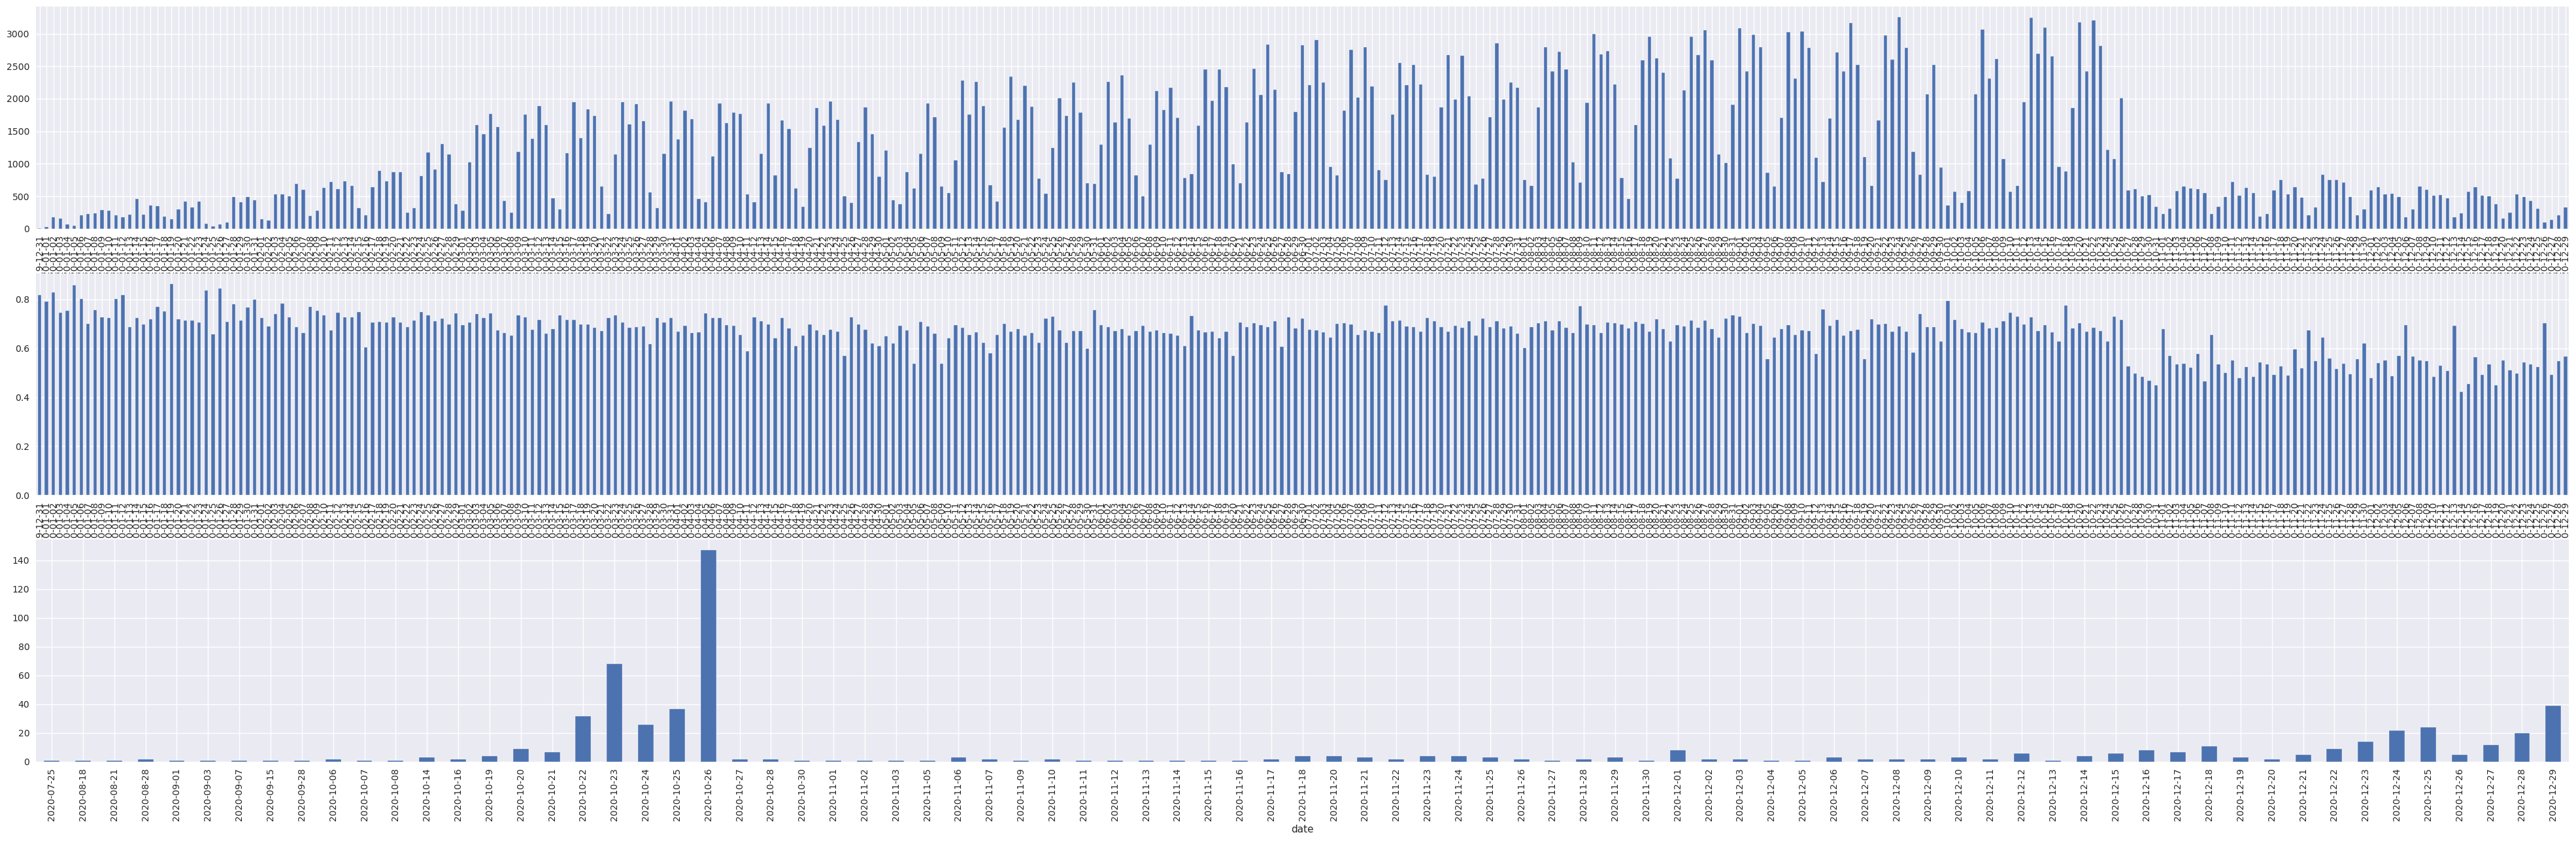

--- group3 INFORMATIONS ---
    shape            : (453432, 25)
    userID           : 788
    assessmentItemID : 9447
    testID           : 1536
    mean answer rate : 65.38%
    KnowledgeTag     : 912
--------------------------
--- group3 valid INFORMATIONS ---
    shape            : (788, 25)
    userID           : 788
    assessmentItemID : 436
    testID           : 389
    mean answer rate : 47.59%
    KnowledgeTag     : 266
--------------------------


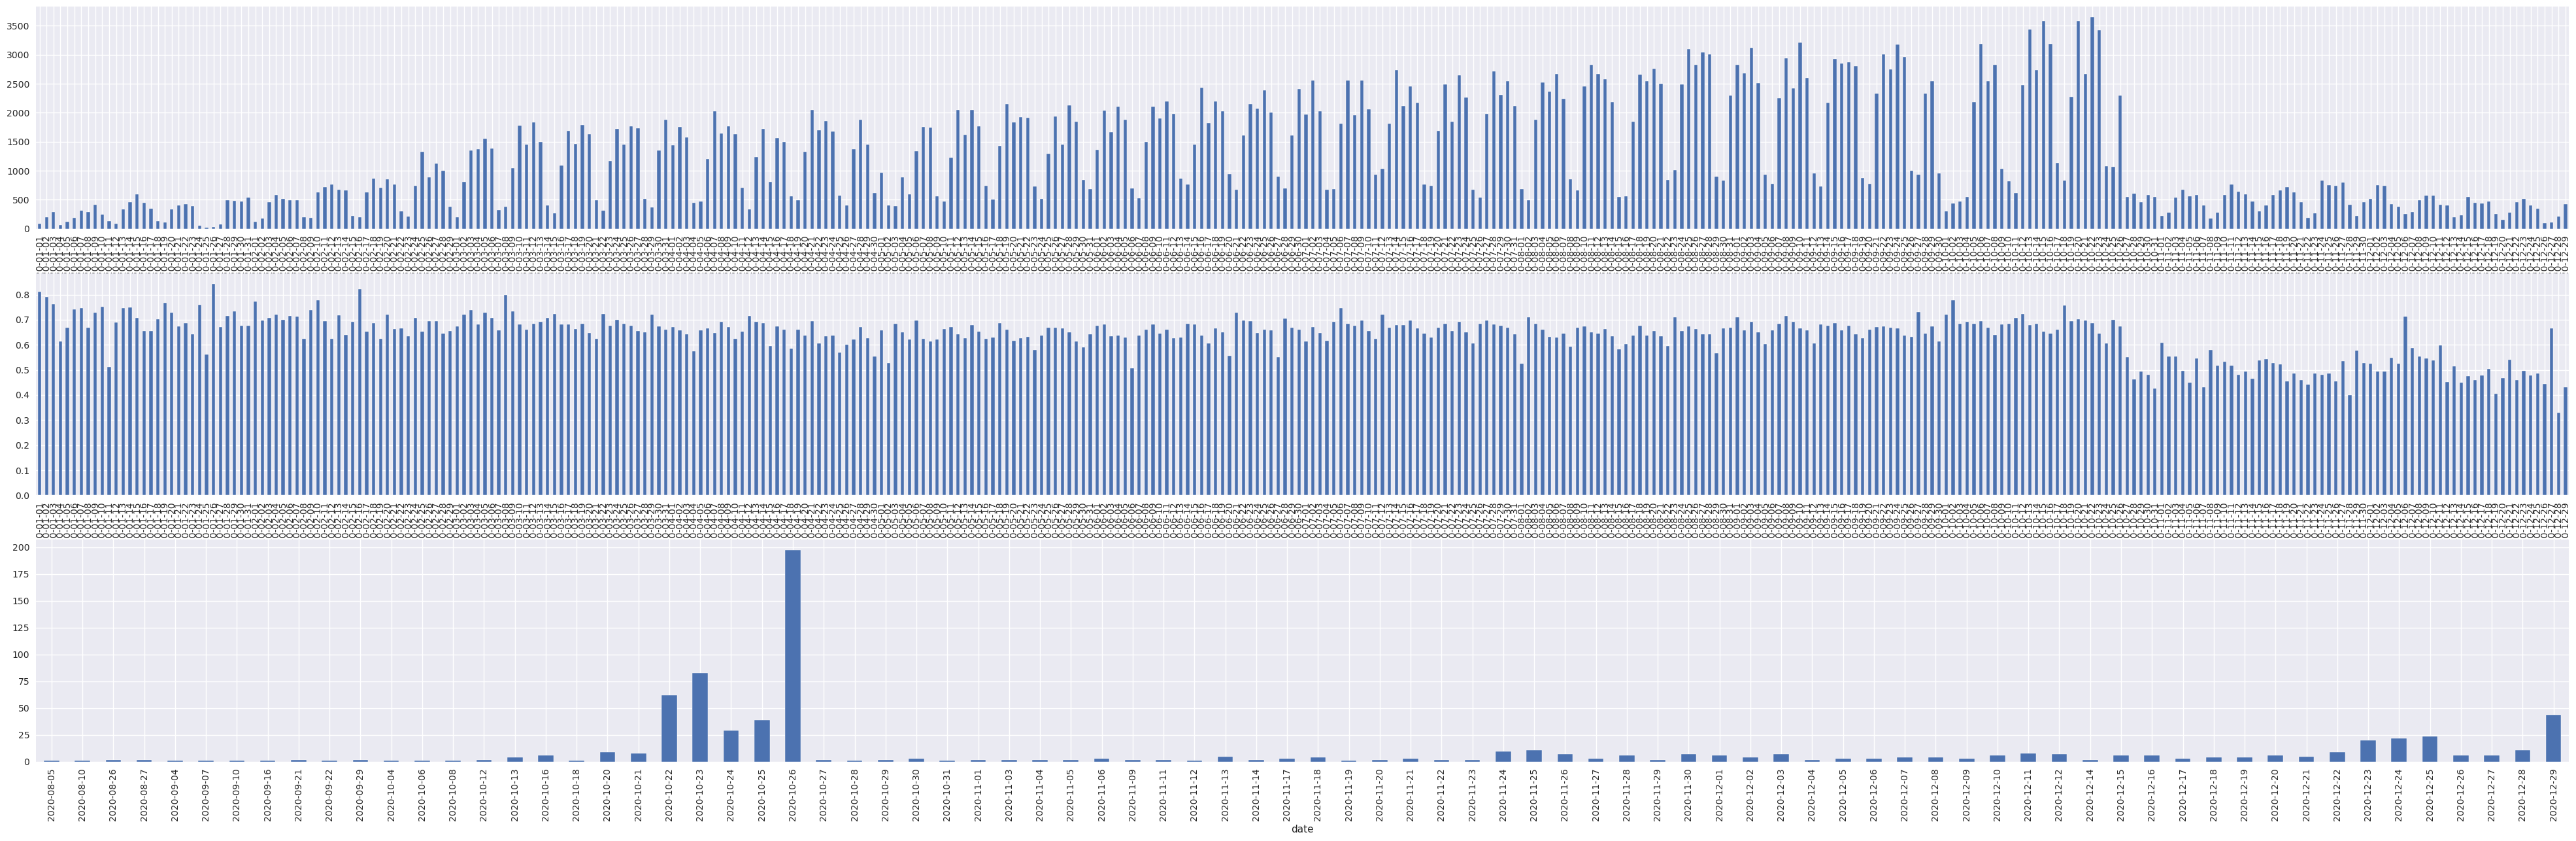

--- group4 INFORMATIONS ---
    shape            : (453145, 25)
    userID           : 1086
    assessmentItemID : 9454
    testID           : 1537
    mean answer rate : 64.76%
    KnowledgeTag     : 912
--------------------------
--- group4 valid INFORMATIONS ---
    shape            : (1086, 25)
    userID           : 1086
    assessmentItemID : 553
    testID           : 493
    mean answer rate : 48.80%
    KnowledgeTag     : 308
--------------------------


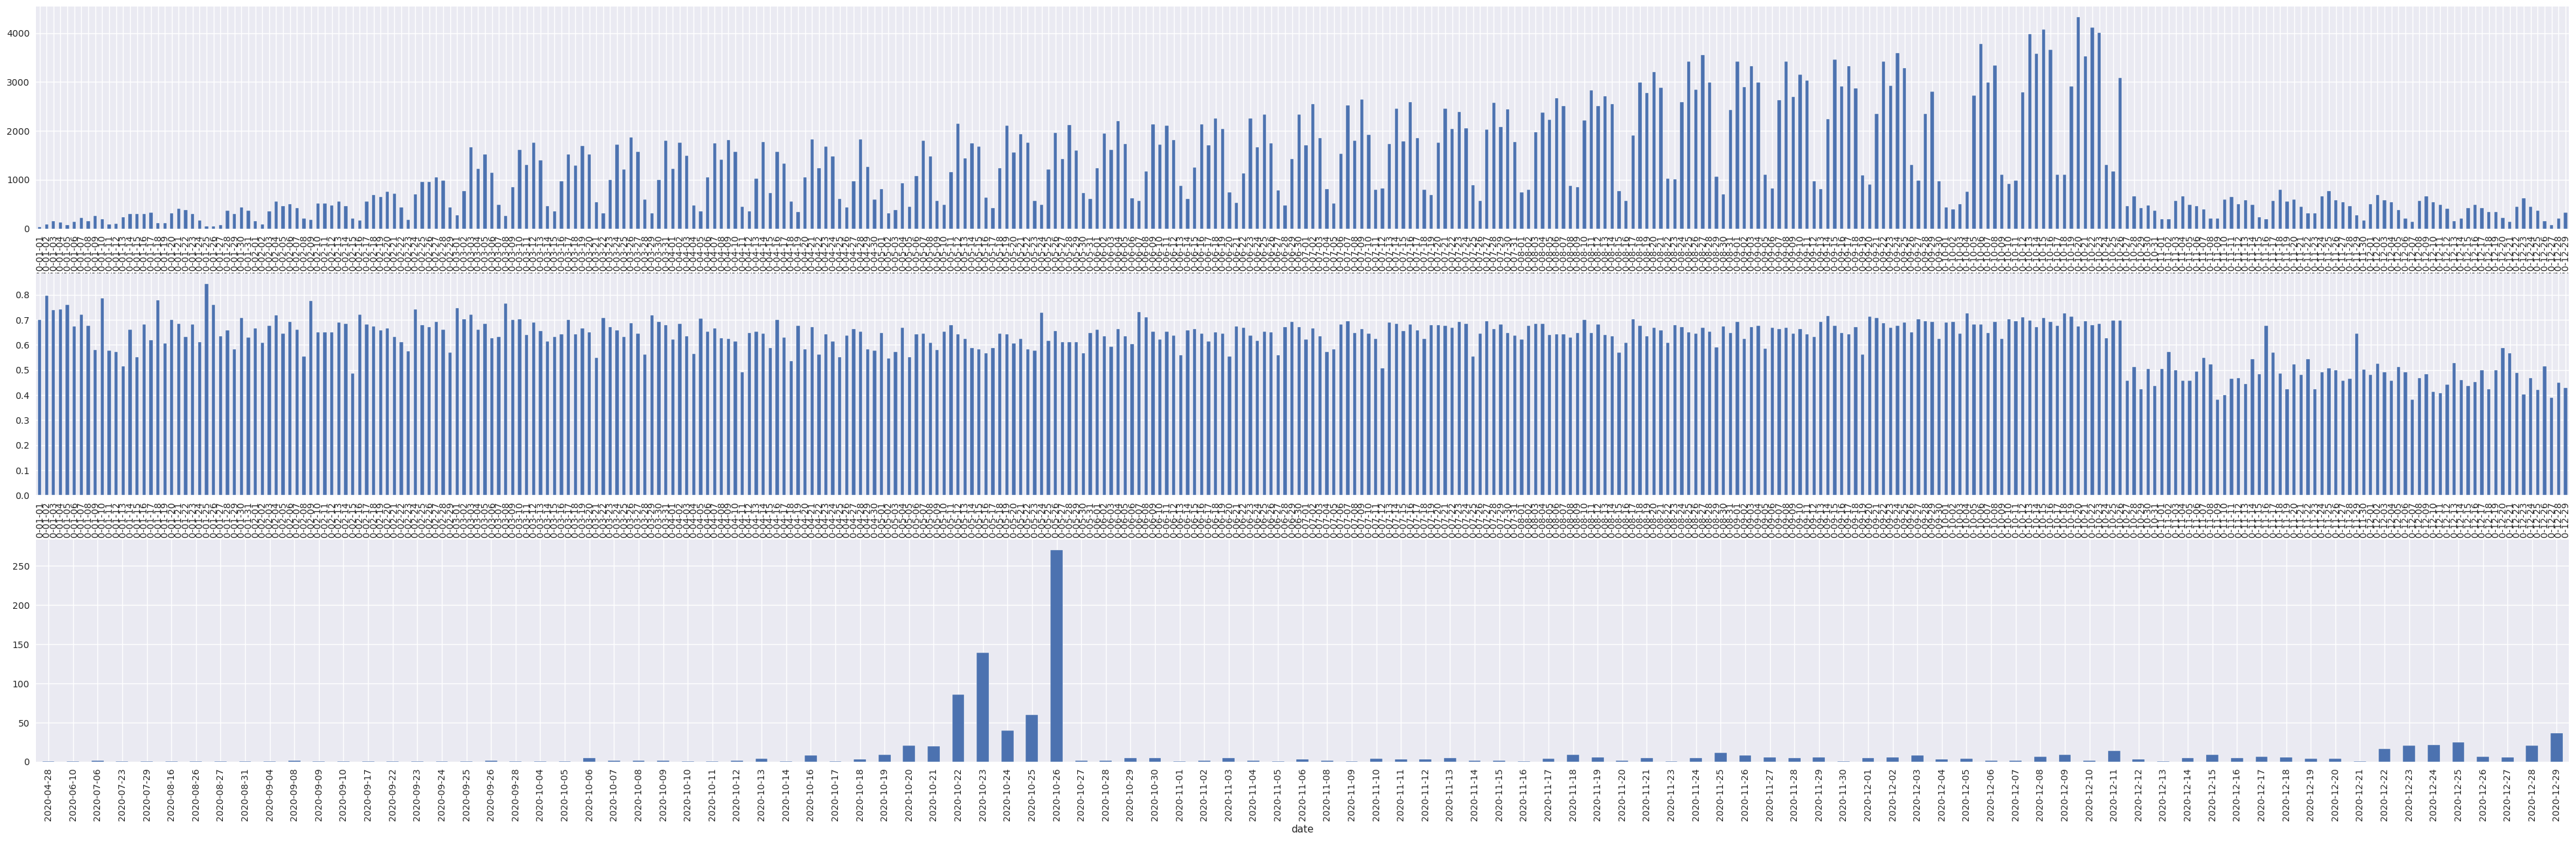

--- group5 INFORMATIONS ---
    shape            : (453136, 25)
    userID           : 3628
    assessmentItemID : 9454
    testID           : 1537
    mean answer rate : 62.82%
    KnowledgeTag     : 912
--------------------------
--- group5 valid INFORMATIONS ---
    shape            : (3628, 25)
    userID           : 3628
    assessmentItemID : 883
    testID           : 720
    mean answer rate : 47.55%
    KnowledgeTag     : 419
--------------------------


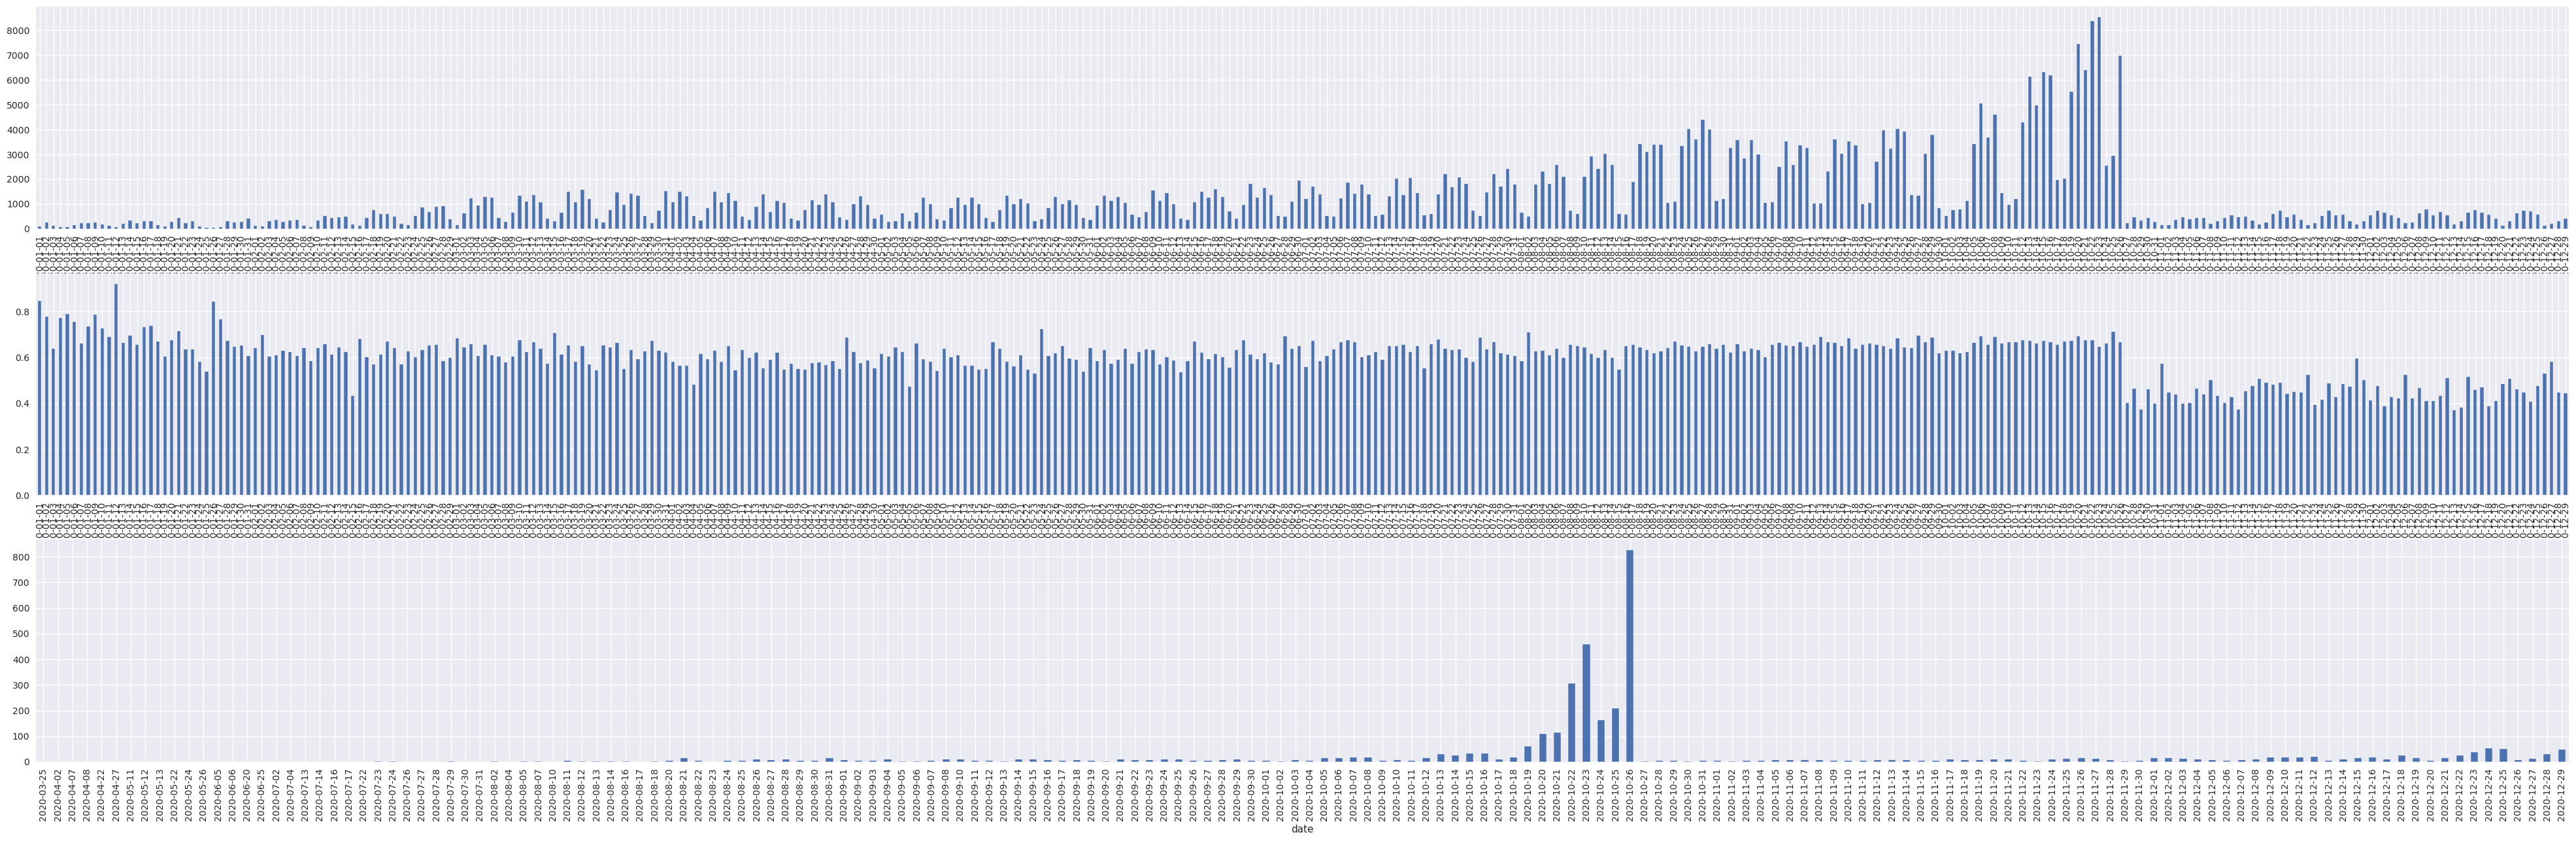

In [275]:
for g in sorted(train_fe.group.unique()):
    sub = train_fe[train_fe.group==g]
    print(f"""--- group{g} INFORMATIONS ---
    shape            : {sub.shape}
    userID           : {sub.userID.nunique()}
    assessmentItemID : {sub.assessmentItemID.nunique()}
    testID           : {sub.testId.nunique()}
    mean answer rate : {sub.answerCode.sum() / sub.shape[0] * 100:.2f}%
    KnowledgeTag     : {sub.KnowledgeTag.nunique()}
{'-'*26}""")
    sub_valid = sub[sub.valid==1]
    print(f"""--- group{g} valid INFORMATIONS ---
    shape            : {sub_valid.shape}
    userID           : {sub_valid.userID.nunique()}
    assessmentItemID : {sub_valid.assessmentItemID.nunique()}
    testID           : {sub_valid.testId.nunique()}
    mean answer rate : {sub_valid.answerCode.sum() / sub_valid.shape[0] * 100:.2f}%
    KnowledgeTag     : {sub_valid.KnowledgeTag.nunique()}
{'-'*26}""")

    q = plt.figure(figsize=(50,15))
    q = plt.subplot(3,1,1)
    q = sub.groupby(['date']).size().plot(kind = 'bar')
    q = plt.subplot(3,1,2)
    q = sub.groupby('date')['answerCode'].mean().plot(kind = 'bar')
    q = plt.subplot(3,1,3)
    q = sub_valid.groupby(['date']).size().plot(kind = 'bar')
    q = plt.show()

### test set

In [405]:
test1_fe['group']=6
test1_fe['valid']=0
test1_fe.loc[test1_fe['userID'] != test1_fe['userID'].shift(-1),'valid']=1

--- test1_fe INFORMATIONS ---
shape            : (259370, 23)
userID           : 744
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.69%
KnowledgeTag     : 912
--------------------------


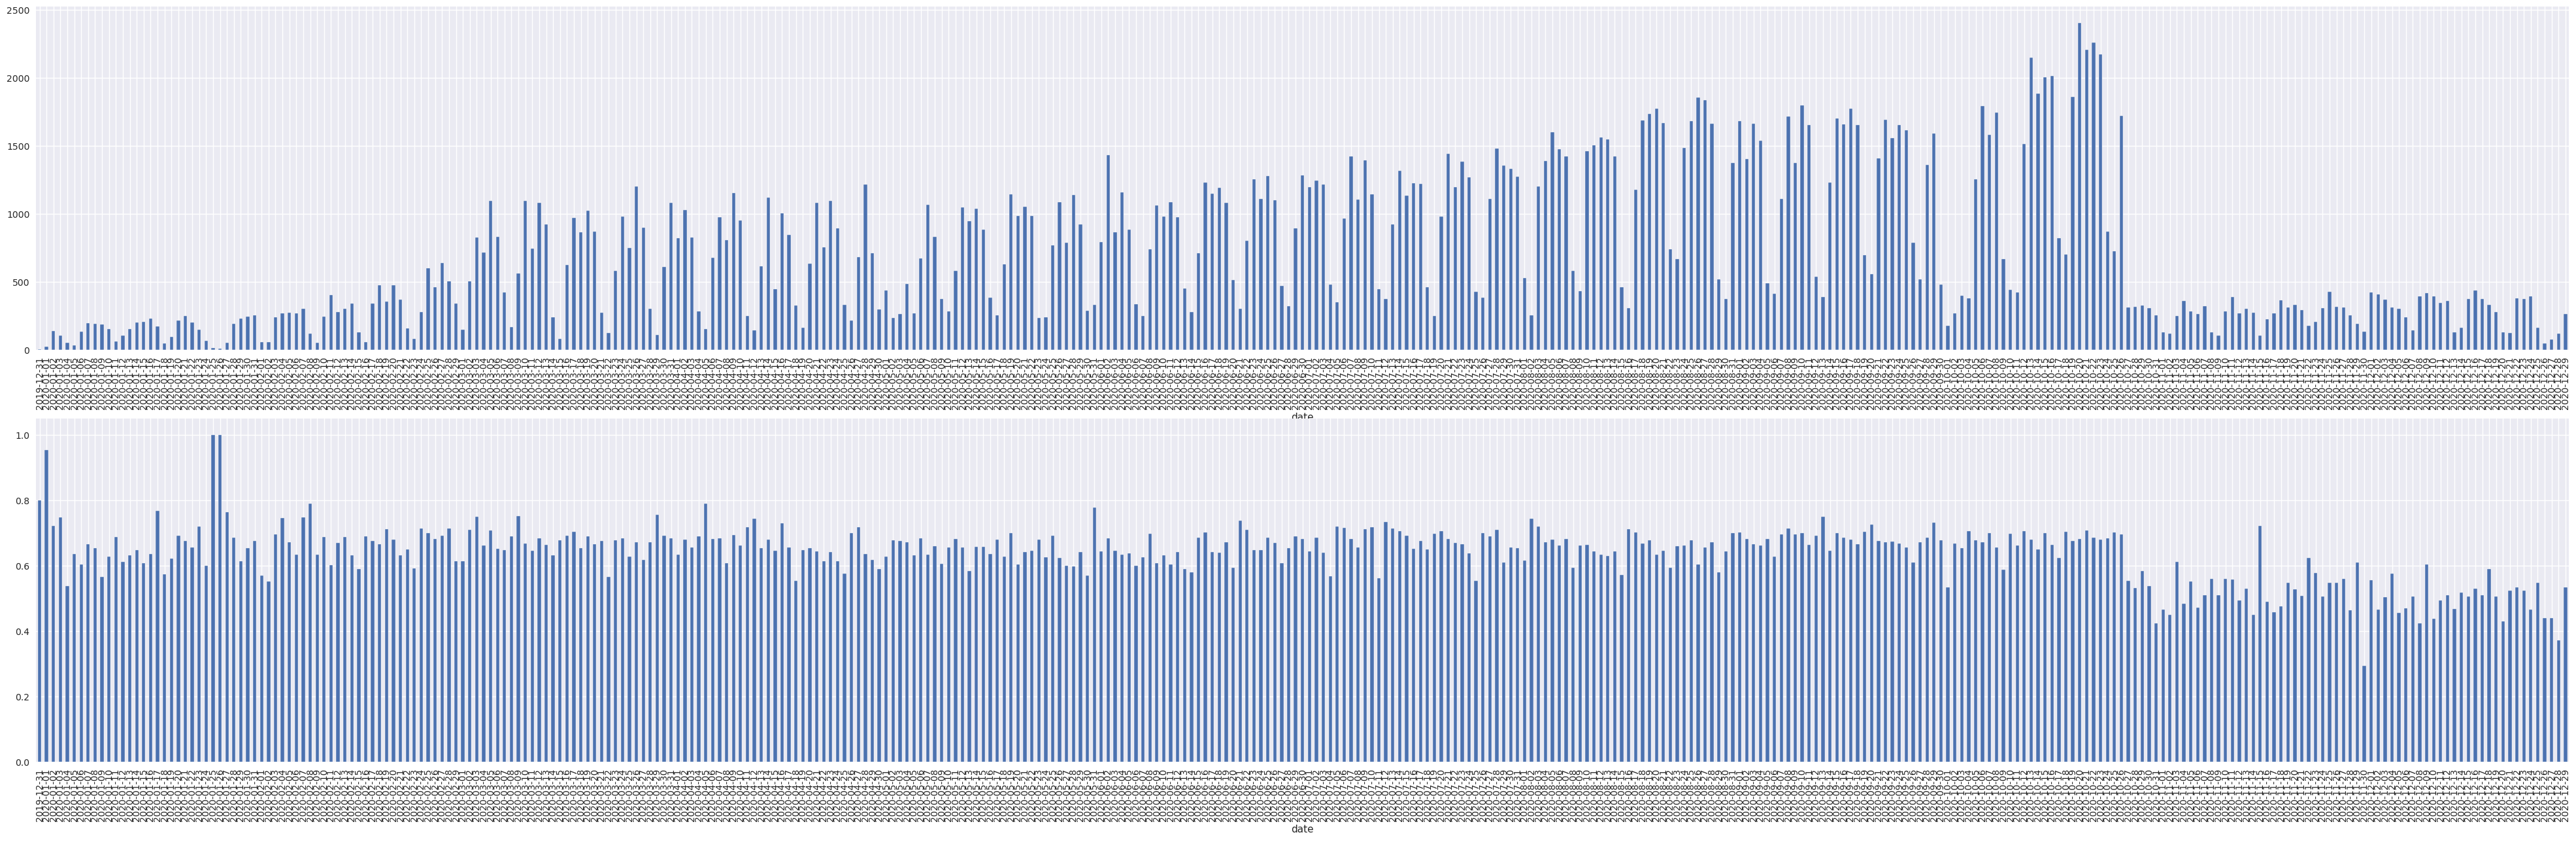

In [277]:
print(f"""--- test1_fe INFORMATIONS ---
shape            : {test1_fe.shape}
userID           : {test1_fe.userID.nunique()}
assessmentItemID : {test1_fe.assessmentItemID.nunique()}
testID           : {test1_fe.testId.nunique()}
mean answer rate : {test1_fe.answerCode.sum() / test1_fe.shape[0] * 100:.2f}%
KnowledgeTag     : {test1_fe.KnowledgeTag.nunique()}
{'-'*26}""")

q = plt.figure(figsize=(50,15))
q = plt.subplot(2,1,1)
q = test1_fe.groupby(['date']).size().plot(kind = 'bar')
q = plt.subplot(2,1,2)
q = test1_fe.groupby('date')['answerCode'].mean().plot(kind = 'bar')

--- test_valid INFORMATIONS ---
shape            : (744, 24)
userID           : 744
assessmentItemID : 452
testID           : 411
mean answer rate : 55.51%
KnowledgeTag     : 277
--------------------------


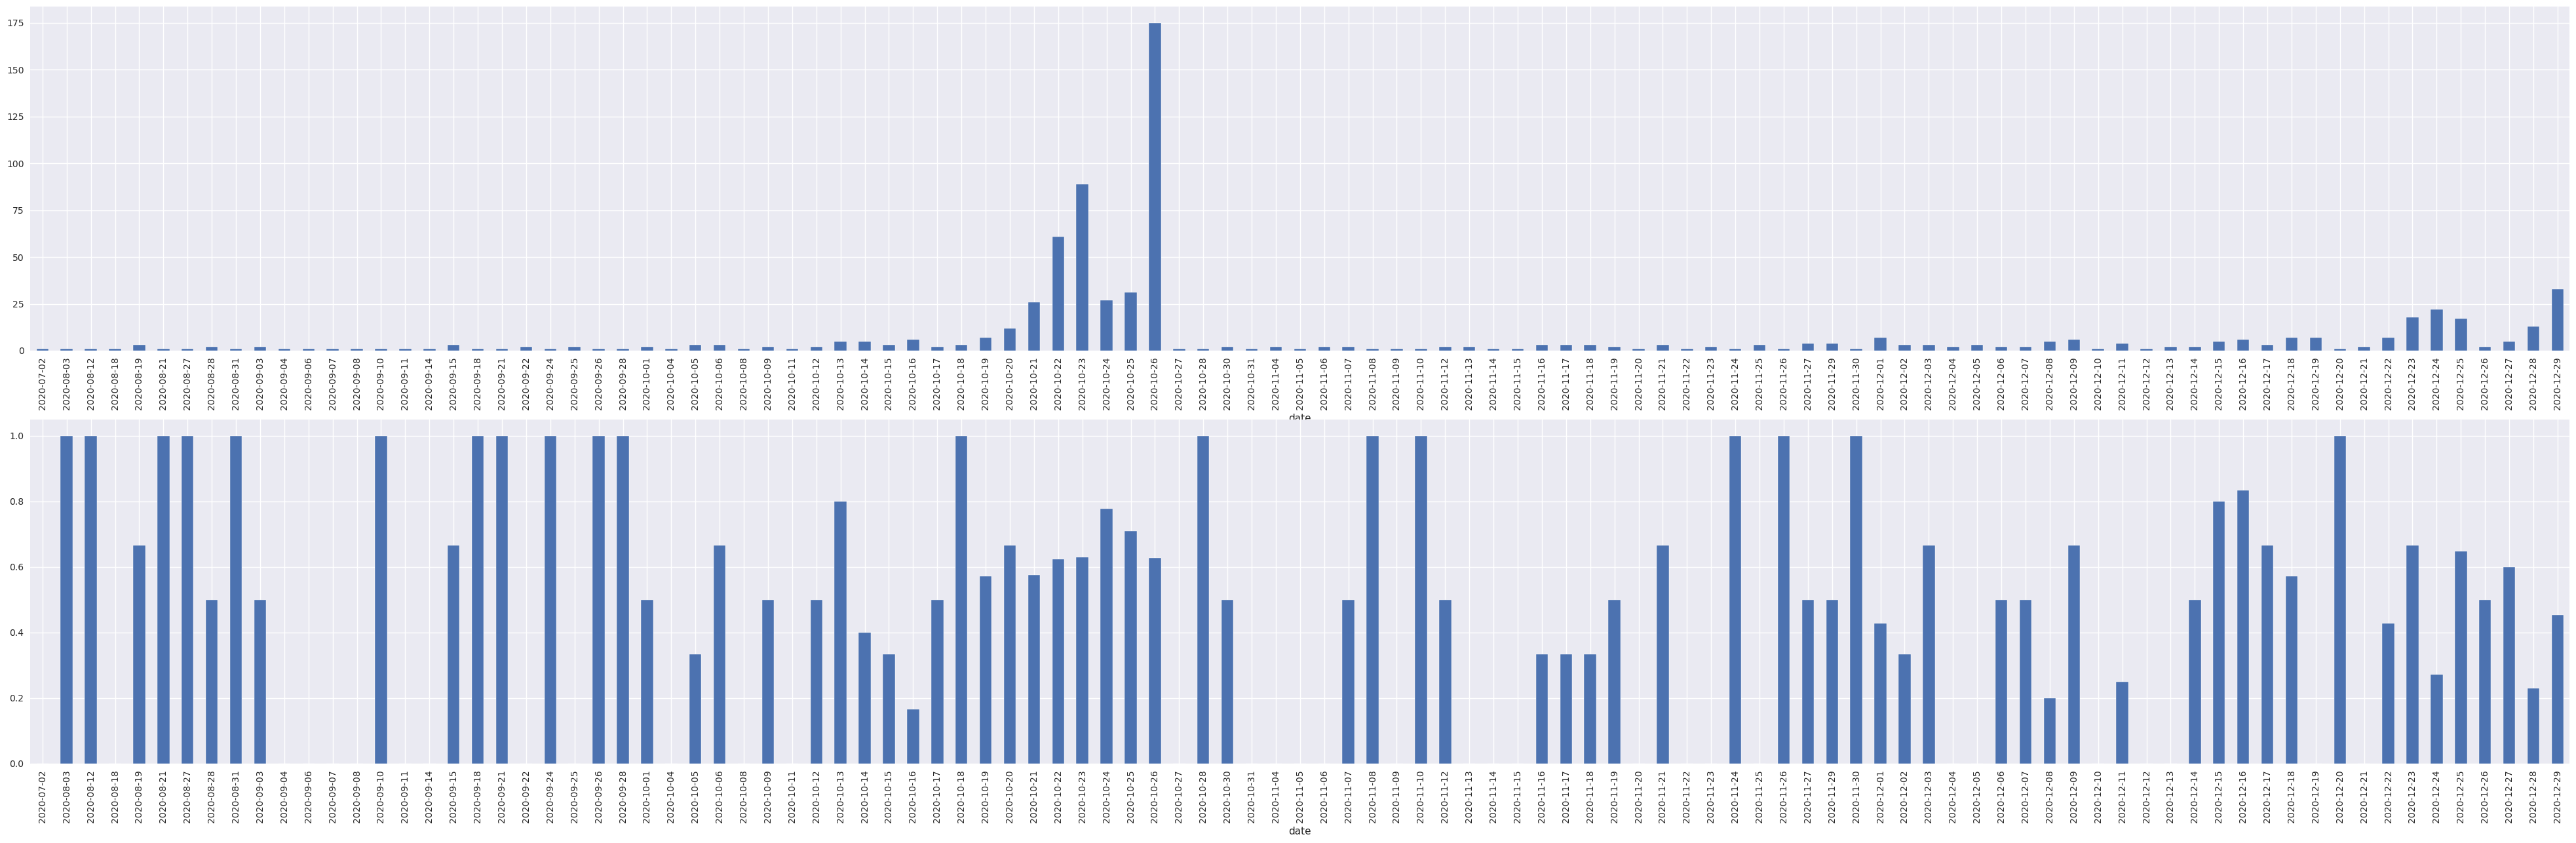

In [367]:
test_valid = test1_fe[test1_fe.valid==1]
print(f"""--- test_valid INFORMATIONS ---
shape            : {test_valid.shape}
userID           : {test_valid.userID.nunique()}
assessmentItemID : {test_valid.assessmentItemID.nunique()}
testID           : {test_valid.testId.nunique()}
mean answer rate : {test_valid.answerCode.sum() / test_valid.shape[0] * 100:.2f}%
KnowledgeTag     : {test_valid.KnowledgeTag.nunique()}
{'-'*26}""")

q = plt.figure(figsize=(50,15))
q = plt.subplot(2,1,1)
q = test_valid.groupby(['date']).size().plot(kind = 'bar')
q = plt.subplot(2,1,2)
q = test_valid.groupby('date')['answerCode'].mean().plot(kind = 'bar')

--- test2_fe INFORMATIONS ---
shape            : (744, 23)
userID           : 744
assessmentItemID : 444
testID           : 411
mean answer rate : -100.00%
KnowledgeTag     : 273
--------------------------


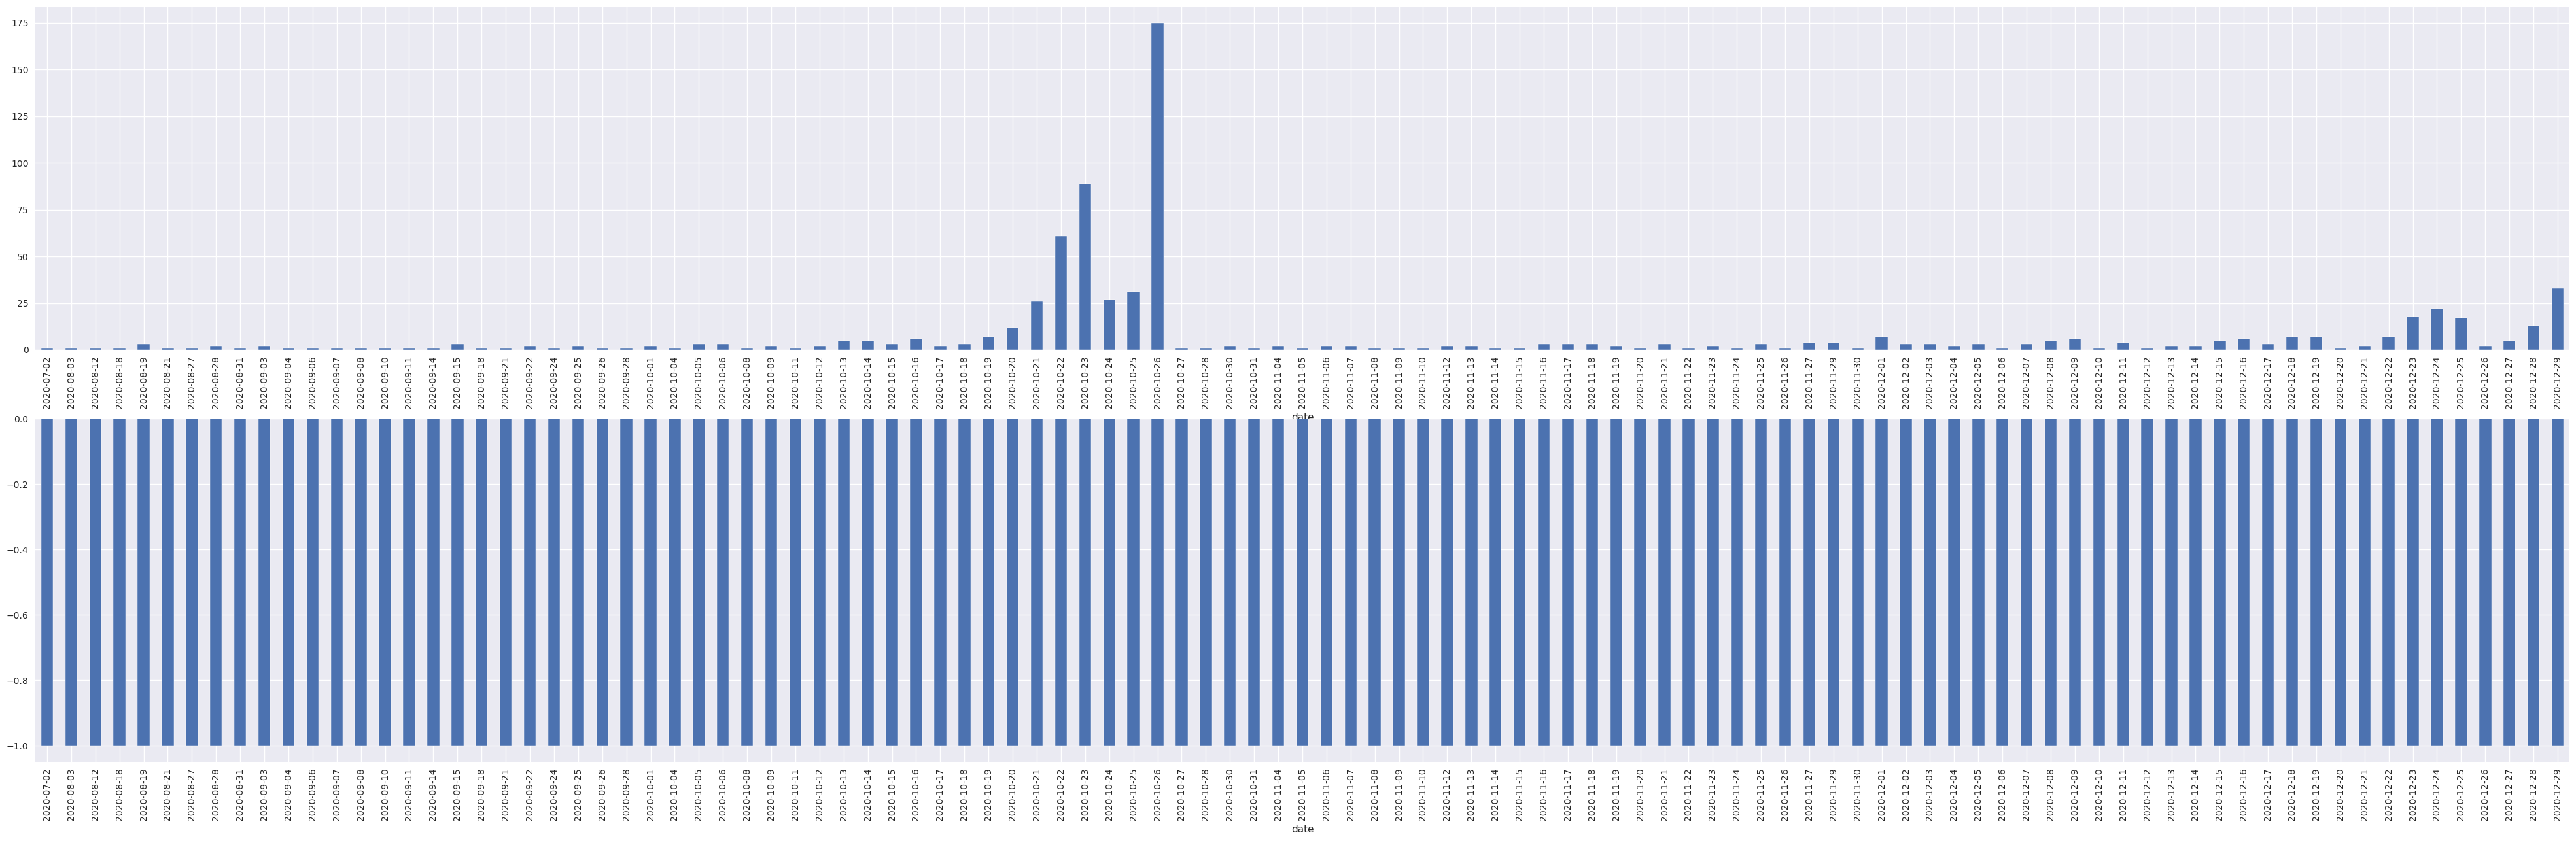

In [278]:
print(f"""--- test2_fe INFORMATIONS ---
shape            : {test2_fe.shape}
userID           : {test2_fe.userID.nunique()}
assessmentItemID : {test2_fe.assessmentItemID.nunique()}
testID           : {test2_fe.testId.nunique()}
mean answer rate : {test2_fe.answerCode.sum() / test2_fe.shape[0] * 100:.2f}%
KnowledgeTag     : {test2_fe.KnowledgeTag.nunique()}
{'-'*26}""")

q = plt.figure(figsize=(50,15))
q = plt.subplot(2,1,1)
q = test2_fe.groupby(['date']).size().plot(kind = 'bar')
q = plt.subplot(2,1,2)
q = test2_fe.groupby('date')['answerCode'].mean().plot(kind = 'bar')

### all set

## StratifiedGroupKFold 사용해보기
```python
>>> import numpy as np
>>> from sklearn.model_selection import StratifiedGroupKFold
>>> X = np.ones((17, 2))
>>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
>>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
>>> cv = StratifiedGroupKFold(n_splits=3)
>>> for train_idxs, test_idxs in cv.split(X, y, groups):
...     print("TRAIN:", groups[train_idxs])
...     print("      ", y[train_idxs])
...     print(" TEST:", groups[test_idxs])
...     print("      ", y[test_idxs])
TRAIN: [1 1 2 2 4 5 5 5 5 8 8]
       [0 0 1 1 1 0 0 0 0 0 0]
 TEST: [3 3 3 6 6 7]
       [1 1 1 0 0 0]
TRAIN: [3 3 3 4 5 5 5 5 6 6 7]
       [1 1 1 1 0 0 0 0 0 0 0]
 TEST: [1 1 2 2 8 8]
       [0 0 1 1 0 0]
TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
       [0 0 1 1 1 1 1 0 0 0 0 0]
 TEST: [4 5 5 5 5]
       [1 0 0 0 0]
```

링크: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html

In [345]:
from sklearn.model_selection import StratifiedGroupKFold

cv = StratifiedGroupKFold(n_splits=5)

x = train_fe.drop('answerCode',axis=1)
y = train_fe['answerCode']

for k, (train_idx, test_idx) in enumerate(cv.split(x,y,train_fe.group),1):
    x_train = x.iloc[train_idx,:]
    x_val = x.iloc[test_idx,:]
    x_valid = x_val[x_val.valid==1]
    print(k, x_train.shape, x_val.shape, x_valid.shape)

1 (1813684, 24) (452902, 24) (633, 24)
2 (1812615, 24) (453971, 24) (563, 24)
3 (1813154, 24) (453432, 24) (788, 24)
4 (1813441, 24) (453145, 24) (1086, 24)
5 (1813450, 24) (453136, 24) (3628, 24)


## LGBM 활용해서 돌려보기

In [313]:
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from eli5.sklearn import PermutationImportance

# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    ## (user_id, 문제푼 횟수)를 원소로 갖는 리스트
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users) # 셔플
    
    max_train_data_len = ratio*len(df) # train data 길이
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users: # for문으로 전체의 ratio 퍼센트만 user_ids에 추가
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    ## train, test split
    train = df[df['userID'].isin(user_ids)] # train
    test = df[df['userID'].isin(user_ids) == False] # test

    #test데이터셋은, train에서 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

### 기존 custom_train_test_split

In [321]:
# 유저별 분리
train, valid = custom_train_test_split(train_fe)

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_valid = valid['answerCode']
valid = valid.drop(['answerCode'], axis=1)

In [325]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std', 'tag_std',
         'tag_mean',
         'tag_sum',
        ]

params = {
    "max_depth": 8,  # 8,
    "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
    "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.01,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
    "num_leaves": 80,  # 40,
    "metric": "auc",
}

model = lgb.LGBMClassifier(
    **params,
    n_estimators=3200,
    silent=-1,
)

model.fit(
    X=train[FEATS],
    y=y_train,
    early_stopping_rounds=100,
    eval_set=[(train[FEATS], y_train), (valid[FEATS], y_valid)],
    eval_names=["train", "valid"],
    eval_metric="roc_auc",
    verbose=100,
)

preds = model.predict_proba(valid[FEATS])[:, 1]
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.747048	valid's auc: 0.696873
[200]	train's auc: 0.750585	valid's auc: 0.701798
[300]	train's auc: 0.753739	valid's auc: 0.705299
[400]	train's auc: 0.756321	valid's auc: 0.709269
[500]	train's auc: 0.758549	valid's auc: 0.71201
[600]	train's auc: 0.760158	valid's auc: 0.713267
[700]	train's auc: 0.761624	valid's auc: 0.714206
[800]	train's auc: 0.762821	valid's auc: 0.714704
[900]	train's auc: 0.763881	valid's auc: 0.715282
[1000]	train's auc: 0.764741	valid's auc: 0.715662
[1100]	train's auc: 0.765592	valid's auc: 0.715959
[1200]	train's auc: 0.766355	valid's auc: 0.7163
[1300]	train's auc: 0.767163	valid's auc: 0.717

LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

In [341]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission_lgbm_before_CV_Strategy.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    q=w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        q=w.write('{},{}\n'.format(id,p))

writing prediction : output/submission_lgbm_before_CV_Strategy2.csv


### StratifiedGroupKFold

In [357]:
from sklearn.model_selection import StratifiedGroupKFold

n_splits = 5
k_auc_list = list()

cv = StratifiedGroupKFold(n_splits=n_splits)

x = train_fe.drop('answerCode',axis=1)
y = train_fe['answerCode']

for k, (train_idx, valid_idx) in enumerate(cv.split(x,y,train_fe.group),1):
    
    # train 분리
    train = x.iloc[train_idx]
    y_train = y.iloc[train_idx]
    
    # valid 분리
    val = x.iloc[valid_idx]
    valid = val[val.valid==1]
    y_valid = y.iloc[valid.index]

    model = lgb.LGBMClassifier(
    **params,
    n_estimators=3200,
    silent=-1,
    )

    model.fit(
        X=train[FEATS],
        y=y_train,
        early_stopping_rounds=100,
        eval_set=[(train[FEATS], y_train), (valid[FEATS], y_valid)],
        eval_names=["train", "valid"],
        eval_metric="roc_auc",
        verbose=100,
    )
    
    preds = model.predict_proba(valid[FEATS])[:, 1]
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    k_auc_list.append(auc)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.746754	valid's auc: 0.689575
[200]	train's auc: 0.750222	valid's auc: 0.6948
[300]	train's auc: 0.753307	valid's auc: 0.699272
[400]	train's auc: 0.755827	valid's auc: 0.702198
[500]	train's auc: 0.757997	valid's auc: 0.703875
[600]	train's auc: 0.759485	valid's auc: 0.704919
[700]	train's auc: 0.760827	valid's auc: 0.705712
[800]	train's auc: 0.761899	valid's auc: 0.706515
[900]	train's auc: 0.762899	valid's auc: 0.706374


LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.747791	valid's auc: 0.676051
[200]	train's auc: 0.751341	valid's auc: 0.68517
[300]	train's auc: 0.75441	valid's auc: 0.691102
[400]	train's auc: 0.756862	valid's auc: 0.697299
[500]	train's auc: 0.758953	valid's auc: 0.699508
[600]	train's auc: 0.760554	valid's auc: 0.700921
[700]	train's auc: 0.761925	valid's auc: 0.701628
[800]	train's auc: 0.763111	valid's auc: 0.7026
[900]	train's auc: 0.764027	valid's auc: 0.701956


LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.746454	valid's auc: 0.690366
[200]	train's auc: 0.750013	valid's auc: 0.696659
[300]	train's auc: 0.753074	valid's auc: 0.70041
[400]	train's auc: 0.755715	valid's auc: 0.703109
[500]	train's auc: 0.758	valid's auc: 0.705369
[600]	train's auc: 0.759796	valid's auc: 0.706247
[700]	train's auc: 0.761289	valid's auc: 0.70708
[800]	train's auc: 0.76246	valid's auc: 0.708074
[900]	train's auc: 0.763525	valid's auc: 0.709114
[1000]	train's auc: 0.764403	valid's auc: 0.709488
[1100]	train's auc: 0.765197	valid's auc: 0.709831
[1200]	train's auc: 0.765997	valid's auc: 0.710121
[1300]	train's auc: 0.766714	valid's auc: 0.710534

LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.746262	valid's auc: 0.704815
[200]	train's auc: 0.749844	valid's auc: 0.708689
[300]	train's auc: 0.752852	valid's auc: 0.710393
[400]	train's auc: 0.755317	valid's auc: 0.712671
[500]	train's auc: 0.757606	valid's auc: 0.714626
[600]	train's auc: 0.759341	valid's auc: 0.715393
[700]	train's auc: 0.76079	valid's auc: 0.715244


LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.747663	valid's auc: 0.692203
[200]	train's auc: 0.751158	valid's auc: 0.695088
[300]	train's auc: 0.75411	valid's auc: 0.698334
[400]	train's auc: 0.756316	valid's auc: 0.699503
[500]	train's auc: 0.758517	valid's auc: 0.700557
[600]	train's auc: 0.760164	valid's auc: 0.700665


LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

In [359]:
kfold_auc = sum(k_auc_list) / n_splits
kfold_auc

0.7075827514934273

In [371]:
model.predict_proba(test_df[FEATS])[:,1]

744

In [365]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission_lgbm_after_CV_Strategy.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    q=w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        q=w.write('{},{}\n'.format(id,p))

writing prediction : output/submission_lgbm_after_CV_Strategy.csv


## LGBMClassifier와 lgb 차이
-> 없다

In [394]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std', 'tag_std',
         'tag_mean',
         'tag_sum',
        ]

params = {
    "max_depth": 8,  # 8,
    "min_data_in_leaf": 1000,
    "bagging_fraction": 0.75,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.01,  # 0.01,
    "seed": 42,
    "num_leaves": 80,  # 40,
    "metric": "auc",
}

model = lgb.LGBMClassifier(
    **params,
    n_estimators=100,
    silent=-1,
)

model.fit(
    X=train[FEATS],
    y=y_train,
    early_stopping_rounds=100,
    eval_set=[(train[FEATS], y_train), (valid[FEATS], y_valid)],
    eval_names=["train", "valid"],
    eval_metric="roc_auc",
    verbose=100,
)

preds1 = model.predict_proba(valid[FEATS])[:, 1]
acc1 = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc1 = roc_auc_score(y_valid, preds)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.747663	valid's auc: 0.692203


LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000, num_leaves=80,
               objective='binary', seed=42, silent=-1)

In [395]:
params = {
    "max_depth": 8,  # 8,
    "min_data_in_leaf": 1000,
    "bagging_fraction": 0.75,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.01,  # 0.01,
    "seed": 42,
    "num_leaves": 80,  # 40,
    "metric": "auc",
}
lgb_train_main = lgb.Dataset(train[FEATS], y_train)
lgb_test_main = lgb.Dataset(valid[FEATS], y_valid)

model_lgb = lgb.train(
    params,
    train_set=lgb_train_main,
    valid_sets=[lgb_train_main,lgb_test_main],
    valid_names=["train", "valid"],
    verbose_eval=100,
    num_boost_round=100,
    early_stopping_rounds=100,
)

preds2 = model_lgb.predict(valid[FEATS])
acc2 = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc2 = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1198527, number of negative: 614923
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 1813450, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.660910 -> initscore=0.667352
[LightGBM] [Info] Start training from score 0.667352
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.747663	valid's auc: 0.692203
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.747663	valid's auc: 0.692203
VALID AUC : 0.6922025482266749 ACC : 0.5791069459757442



In [396]:
preds1

array([0.78030173, 0.43277076, 0.50389938, ..., 0.67756388, 0.56779036,
       0.60543372])

In [397]:
preds2

array([0.78030173, 0.43277076, 0.50389938, ..., 0.67756388, 0.56779036,
       0.60543372])

## train 전부 + test 마지막 2까지 Stratified

In [411]:
df = pd.concat([train_fe,test1_fe])

In [413]:
df.group.unique()

array([1, 2, 3, 4, 5, 6])

In [414]:
df[df.valid==1].shape

(7442, 25)

In [418]:
params

{'max_depth': 8,
 'min_data_in_leaf': 1000,
 'bagging_fraction': 0.75,
 'objective': 'binary',
 'boosting': 'gbdt',
 'learning_rate': 0.01,
 'seed': 42,
 'num_leaves': 80,
 'metric': 'auc'}

In [416]:
from sklearn.model_selection import StratifiedGroupKFold

n_splits = 6
k_auc_list = list()

cv = StratifiedGroupKFold(n_splits=n_splits)

x = df.drop('answerCode',axis=1)
y = df['answerCode']

for k, (train_idx, valid_idx) in enumerate(cv.split(x,y,df.group),1):
    
    # train 분리
    train = x.iloc[train_idx]
    y_train = y.iloc[train_idx]
    
    # valid 분리
    val = x.iloc[valid_idx]
    valid = val[val.valid==1]
    y_valid = y.iloc[valid.index]

    model = lgb.LGBMClassifier(
    **params,
    n_estimators=3200,
    silent=-1,
    )

    model.fit(
        X=train[FEATS],
        y=y_train,
        early_stopping_rounds=100,
        eval_set=[(train[FEATS], y_train), (valid[FEATS], y_valid)],
        eval_names=["train", "valid"],
        eval_metric="roc_auc",
        verbose=100,
    )
    
    preds = model.predict_proba(valid[FEATS])[:, 1]
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    k_auc_list.append(auc)
kfold_auc = sum(k_auc_list) / n_splits

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.747642	valid's auc: 0.6773
[200]	train's auc: 0.750942	valid's auc: 0.685952
[300]	train's auc: 0.753908	valid's auc: 0.691102
[400]	train's auc: 0.756274	valid's auc: 0.696012
[500]	train's auc: 0.758253	valid's auc: 0.698637
[600]	train's auc: 0.759747	valid's auc: 0.699407
[700]	train's auc: 0.76095	valid's auc: 0.699053


LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.746475	valid's auc: 0.687771
[200]	train's auc: 0.749799	valid's auc: 0.692836
[300]	train's auc: 0.752753	valid's auc: 0.697718
[400]	train's auc: 0.755214	valid's auc: 0.700223
[500]	train's auc: 0.757249	valid's auc: 0.701372
[600]	train's auc: 0.758772	valid's auc: 0.702521
[700]	train's auc: 0.760137	valid's auc: 0.704226
[800]	train's auc: 0.761242	valid's auc: 0.704962
[900]	train's auc: 0.762168	valid's auc: 0.705511
[1000]	train's auc: 0.762934	valid's auc: 0.705847
[1100]	train's auc: 0.763648	valid's auc: 0.706305
[1200]	train's auc: 0.764321	valid's auc: 0.706783
[1300]	train's auc: 0.765011	valid's auc: 0.

LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.74632	valid's auc: 0.70141
[200]	train's auc: 0.749647	valid's auc: 0.70441
[300]	train's auc: 0.752512	valid's auc: 0.705523
[400]	train's auc: 0.754863	valid's auc: 0.707408
[500]	train's auc: 0.756791	valid's auc: 0.70886
[600]	train's auc: 0.758345	valid's auc: 0.710116
[700]	train's auc: 0.75986	valid's auc: 0.710472
[800]	train's auc: 0.760995	valid's auc: 0.710968
[900]	train's auc: 0.761945	valid's auc: 0.710707


LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.747477	valid's auc: 0.692184
[200]	train's auc: 0.750736	valid's auc: 0.695277
[300]	train's auc: 0.753611	valid's auc: 0.698381
[400]	train's auc: 0.755732	valid's auc: 0.700292
[500]	train's auc: 0.757738	valid's auc: 0.701255
[600]	train's auc: 0.759102	valid's auc: 0.701645
[700]	train's auc: 0.760478	valid's auc: 0.703154
[800]	train's auc: 0.761572	valid's auc: 0.703844
[900]	train's auc: 0.762448	valid's auc: 0.704191
[1000]	train's auc: 0.763206	valid's auc: 0.704219


LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.746759	valid's auc: 0.687477
[200]	train's auc: 0.750078	valid's auc: 0.692818
[300]	train's auc: 0.752934	valid's auc: 0.696351
[400]	train's auc: 0.755382	valid's auc: 0.698565
[500]	train's auc: 0.757455	valid's auc: 0.701114
[600]	train's auc: 0.758869	valid's auc: 0.70272
[700]	train's auc: 0.76002	valid's auc: 0.703293
[800]	train's auc: 0.760984	valid's auc: 0.704206
[900]	train's auc: 0.761855	valid's auc: 0.705431
[1000]	train's auc: 0.762726	valid's auc: 0.706384
[1100]	train's auc: 0.763457	valid's auc: 0.706716
[1200]	train's auc: 0.764096	valid's auc: 0.706956
[1300]	train's auc: 0.764821	valid's auc: 0.70

LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	train's auc: 0.746694	valid's auc: 0.504455
[200]	train's auc: 0.750199	valid's auc: 0.504262


LGBMClassifier(bagging_fraction=0.75, boosting='gbdt', learning_rate=0.01,
               max_depth=8, metric='auc', min_data_in_leaf=1000,
               n_estimators=3200, num_leaves=80, objective='binary', seed=42,
               silent=-1)

0.672428512072469

In [417]:
kfold_auc

0.672428512072469

In [419]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission_lgbm_after_CV_all_dataset_Strategy.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    q=w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        q=w.write('{},{}\n'.format(id,p))

writing prediction : output/submission_lgbm_after_CV_all_dataset_Strategy.csv


In [421]:
# MAKE PREDICTION
total_preds = model.predict_proba(test_df[FEATS])[:,1]

# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission_lgbm_after_CV_all_dataset_Strategy_proba.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    q=w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        q=w.write('{},{}\n'.format(id,p))

writing prediction : output/submission_lgbm_after_CV_all_dataset_Strategy_proba.csv
